<a href="https://colab.research.google.com/github/jlmarrugom/covid/blob/main/COVID_UC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis Pacientes proyecto Control Box

## EDA Covid 19

Este notebook busca explorar el set de datos de **Pacientes**, sintomáticos y asintomáticos que se hicieron la prueba de covid-19 en el Departamento de Córdoba.

In [ ]:
#@title Requeriments
%%capture
!pip install klib
!pip install ipympl
!pip install bokeh
!pip install catboost
!pip install shapash

#!pip install ipywidgets



from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
import missingno as msno
import folium  #needed for interactive map
from folium.plugins import HeatMap

import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer   

from shapash.explainer.smart_explainer import SmartExplainer


import klib
# %matplotlib widget #Para hacer los gráficos interactivos
# %matplotlib inline #Volver a la normalidad

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g48l5iq_ydwffYUpQB6zcx8thkqaqOEtZSyE3l3iFwvYdp1fyPpLTw


In [ ]:
#@title Geographical Data import

from geopy.exc import GeocoderTimedOut 
from geopy.geocoders import Nominatim 

# function to find the coordinate 
# of a given city 
def findGeocode(city): 
	
	# try and catch is used to overcome 
	# the exception thrown by geolocator 
	# using geocodertimedout 
	try: 
		
		# Specify the user_agent as your 
		# app name it should not be none 
		geolocator = Nominatim(user_agent="your_app_name") 
		
		return geolocator.geocode(str(city)+', Cordoba, Colombia')
	
	except GeocoderTimedOut: 
		
		return findGeocode(city)	

In [ ]:
#@title Importamos los datos y creamos un solo dataset
asin_df = pd.read_excel('/content/drive/MyDrive/Covid UC/CAP_GATEWAY 27 01 2021 NEW.xlsx',sheet_name='BD ASINTOMÁTICOS')
sin_df = pd.read_excel('/content/drive/MyDrive/Covid UC/CAP SINTOMATICOS 27 01 2021 GATEWAY.xlsx', sheet_name='BD sintomaticos')
asin_df['SINTOMAS'] = 0
sin_df['SINTOMAS'] = 1
pat_df = pd.concat([asin_df,sin_df],join='inner')

In [ ]:
#@title Geo referentiation
%%capture
pat_df['MUNICIPIO'] = pat_df['MUNICIPIO'].astype(object).replace({1:'Lorica',
                                                                  2:'Planeta Rica',
                                                                  3:'Tierralta',
                                                                  4:'Sahagun',
                                                                  5:'Montelibano'})
""" #Este es el código que automatiza la recopilación de las coordenadas
#No es muy preciso ya que puede confundir regiones con pueblos o ciudades
#Puede agregarse el 'Town' a la busqueda.

cities = set(list(pat_df["MUNICIPIO"].unique()))
longitude = [] 
latitude = [] 
place = []
for i in (cities): 
  place.append(i)	
	
  if findGeocode(i) != None:
    loc = findGeocode(i)
    latitude.append(loc.latitude)
    longitude.append(loc.longitude)
  else: 
    latitude.append(np.nan) 
    longitude.append(np.nan) 

location = pd.DataFrame()
location["place"] = place
location["lon"] = longitude 
location["lat"] = latitude
location.index = location["place"]
location.to_dict()

pat_df['lat'] = pat_df["MUNICIPIO"].map(location['lat'])
pat_df['lon'] = pat_df["MUNICIPIO"].map(location['lon'])
"""
pat_df['lat']=0
pat_df['lon']=0
pat_df['lat'].loc[pat_df['MUNICIPIO']=='Lorica'] = 9.2394583
pat_df['lon'].loc[pat_df['MUNICIPIO']=='Lorica'] = -75.8139786

pat_df['lat'].loc[pat_df['MUNICIPIO']=='Planeta Rica'] = 8.4076739 
pat_df['lon'].loc[pat_df['MUNICIPIO']=='Planeta Rica'] = -75.5840456 

pat_df['lat'].loc[pat_df['MUNICIPIO']=='Tierralta'] = 8.1717342
pat_df['lon'].loc[pat_df['MUNICIPIO']=='Tierralta'] = -76.059376

pat_df['lat'].loc[pat_df['MUNICIPIO']=='Sahagun'] = 8.9472964
pat_df['lon'].loc[pat_df['MUNICIPIO']=='Sahagun'] = -75.4434972

pat_df['lat'].loc[pat_df['MUNICIPIO']=='Montelibano'] = 7.9800534
pat_df['lon'].loc[pat_df['MUNICIPIO']=='Montelibano'] = -75.4167198

In [ ]:
#@title Tabla para el mapa
%%capture

df = pat_df[pat_df['RESULTADO PCR']=='POSITIVO'] 
df = df.dropna()
# max_amount = float(df['export_val'].max())
df = df[['lat','lon','MUNICIPIO']].groupby('MUNICIPIO').max()
df = df.merge(pat_df[['RESULTADO PCR','MUNICIPIO']].loc[pat_df['RESULTADO PCR']=='POSITIVO'].groupby(['MUNICIPIO']).count() ,how='outer',on='MUNICIPIO')
df = df.merge(pat_df[['RESULTADO PCR','MUNICIPIO']].groupby(['MUNICIPIO']).count() ,how='inner',on='MUNICIPIO')
df = df.merge(pat_df[['RESULTADO SEROLOGIA','MUNICIPIO']].loc[pat_df['RESULTADO SEROLOGIA']=='POSITIVO'].groupby(['MUNICIPIO']).count() ,how='outer',on='MUNICIPIO')
df = df.merge(pat_df[['RESULTADO SEROLOGIA','MUNICIPIO']].groupby(['MUNICIPIO']).count() ,how='inner',on='MUNICIPIO')

#df = df.merge(pat_df[['RESULTADO PCR','MUNICIPIO']].loc[pat_df['RESULTADO PCR']=='POSITIVO'].groupby(['MUNICIPIO']).agg(lambda x:x.value_counts().index[0])

df = df.reset_index()
df.head(5)

In [ ]:
#@title #Conteo por Municipio
folium_hmap = folium.Figure(width=1000, height=500)
m = folium.Map(location=[8.3344713,-75.6666238],
                         width='100%',
                         height='100%',
                         zoom_start=8,#Por defecto es 10
                         tiles="OpenStreetMap").add_to(folium_hmap)

#folium_hmap.fit_bounds([[6.4, -78], [10.4, -73]])
data = df
for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
      popup=str(data.iloc[i]['MUNICIPIO'])+
      '\nTotal de Pruebas Realizadas: \n'+
      str(data.iloc[i]['RESULTADO PCR_y'])+
      '\nPositivas: \n'+
      str(data.iloc[i]['RESULTADO PCR_x'])+
      '\nVulnerabilidad: '+
      str(round(100*(1-(data.iloc[i]['RESULTADO SEROLOGIA_x']/data.iloc[i]['RESULTADO SEROLOGIA_y']))))+
      '%',
      radius=float(data.iloc[i]['RESULTADO PCR_x'])*1000,
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(m)

folium_hmap

### Información Básica de los Datos

Esta información nos permite ver el tipo de variable, y una descripción estadística de los cuartiles, medias, máximos y mínimos.

In [ ]:
#@title Información básica de los datos
pat_df.info()
"""
print(' ')
for i in (pat_df['UTILIZA TRANSPORTE PUBLICO'].value_counts(),
      pat_df['MUNICIPIO'].value_counts(),
      pat_df['AREA DEL MUNICIPIO'].value_counts(),
      pat_df['EDAD'].value_counts(),
      pat_df['OTRO CUAL?'].value_counts(),' Sitio más frecuentado',
      pat_df['CASA DE FAMILIARES'].value_counts(),
      pat_df['RESULTADO PCR'].value_counts(),
      pat_df['RESULTADO SEROLOGIA'].value_counts()):
  print(i)
  print(' ')
"""  
pat_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 822 entries, 0 to 35
Data columns (total 78 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   PRIMER NOMBRE                                          822 non-null    object 
 1   SEGUNDO NOMBRE                                         613 non-null    object 
 2   PRIMER APELLIDO                                        822 non-null    object 
 3   SEGUNDO APELLIDO                                       775 non-null    object 
 4   MUNICIPIO                                              822 non-null    object 
 5   AREA DEL MUNICIPIO                                     794 non-null    float64
 6   DIRECCIÓN                                              822 non-null    object 
 7   TELEFONO                                               822 non-null    object 
 8   EDAD                                               

,AREA DEL MUNICIPIO,SEXO,AFILIACION AL SGSSS,LUGAR DE RESIDENCIA,ESCOLARIDAD,TOMA MEDICAMENTOS,FIEBRE Ó ESCALOFRIOS,TOS,DIFICULTAD PARA RESPIRAR,FATIGA,DOLORES MUSCULARES Y CORPORALES,DOLOR DE CABEZA,PERDIDAD DEL OLFATO O DEL GUSTO,DOLOR DE GARGANTA,CONGESTION DE LA NARIZ,NÁUSEAS O VÓMITOS,DIARREA,LA PERSONA CON COVID ESTUVO AISLADA DE LOS DEMAS?,ALGUIEN COMPARTE HABITACION,USAN MEDIDAS DE PROTECCION DENTRO DE LA CASA,USAN MASCARILLAS O CARETAS DENTRO DE LA VIVIENDA,DURANTE LA PANDEMIA ME HE QUEDADO EN CASA,CUANDO LLEGA DE LA CALLE SE QUITA Y LAVA LA ROPA,SE QUITA LOS ZAPATOS O LOS DESINFECTA,PARA MOVILIZARSE UTILIZA ALGUN ELEMENTO DE PROTECCIÓN,DE LOS ELEMENTOS DE PROTECCIÓN,DESINFECTO TODOS LOS PAQUETES QUE LLEGAN,TIENDA,SUPERMERCADO,CENTRO COMERCIAL,MERCADO,FARMACIA,CENTRO DE SALUD,PARQUE,YO CREO QUE?,SOBRE LA DURACIÓN?,ESTARÍA DISPUESTO A VACUNARME?,DURANTE EL AISLAMIENTO OBLIGATORIO ME HE SENTIDO?,CAMBIÉ MIS HÁBITOS ALIMENTICIOS,AUMENTE DE PESO,VEO MÁS TV,SENTÍ TEMOR DE SALIR DE LA CASA,ME HABRIA AISLADO VOLUNTARIAMENTE,PERDÍ MI TRABAJO,RECIBO AYUDA DEL ESTADO,FORTALECÍ MI RELACIÓN CON MI FAMILIA,ESTUVE DE ACUERDO CON LAS MEDIDAS DEL GOBIER2,HE CAMBIADO DE ACTIVIDAD LABORAL?,¿LA COVID -19 ES?,"FIEBRE,TOS,DOLOR EN EL CUERPO, PERDIDA DE OLFATO","MAREOS, PERDIDA DE APETITO",VOMITOS,SORDERA,EL MAYOR RIESGO LO TIENEN,EL VIRUS SE TRANSMITE POR EL AIRE,SE TRANSMITE POR TOCAR SUPERFICIES EN LA CALLE,SI ME ENFERMO QUE DEBO HACER?,AISLAMIENTO,USO DE TAPABOCAS,DISTANCIAMIENTO SOCIAL,CQ,SINTOMAS,lat,lon
count,794.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,43.000000,822.000000,822.000000,822.000000
mean,1.342569,1.497567,1.690998,1.407543,4.881995,1.796837,1.815085,1.860097,1.920925,1.940389,1.812652,1.779805,1.872263,1.856448,1.884428,1.944039,1.934307,3.367397,3.428224,3.330900,3.386861,2.500000,1.263990,1.552311,1.416058,1.324818,1.701946,1.658151,1.782238,1.993917,1.951338,1.958637,1.923358,2.013382,1.330900,1.929440,2.041363,4.236010,2.013382,1.734793,1.981752,1.855231,2.060827,1.920925,1.762774,1.228710,1.436740,1.929440,1.319951,1.881995,1.875912,1.900243,1.476886,3.025547,1.474453,1.180049,1.425791,1.551095,1.238443,1.326034,31.389654,0.043796,8.626657,-75.646181
std,0.510694,0.500298,0.778450,0.865127,2.125065,0.479890,0.430128,0.390058,0.323388,0.296301,0.429072,0.451206,0.378451,0.393400,0.366071,0.290796,0.316906,1.144306,1.009857,1.178365,1.120607,1.381759,0.757998,0.945050,0.874394,0.742214,0.984643,0.570211,0.520026,0.325471,0.385570,0.373602,0.413198,0.297887,0.794312,1.110194,1.260567,2.239664,0.922617,0.654959,1.014347,1.002902,1.373562,0.470649,0.532433,0.530441,0.837759,0.654701,0.615327,0.621923,0.566356,0.547189,0.683065,0.301162,0.593267,0.533132,0.947446,0.514532,0.443199,0.484376,6.523196,0.204765,0.455955,0.233993
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,17.000000,0.000000,7.980053,-76.059376
25%,1.000000,1.000000,

Podemos notar que el inner join combinando ambos sets de datos fue exitoso, y que solo quedamos con las columnas que tienen en común.

El set de datos es un poco desbalanceado entre los pacientes sintomáticos y los asintomáticos, siendo mayor el set de datos asintomáticos.

### Datos Faltantes

Con esto podemos eliminar variables con gran cantidad de datos faltantes.

Displaying only columns with missing values.


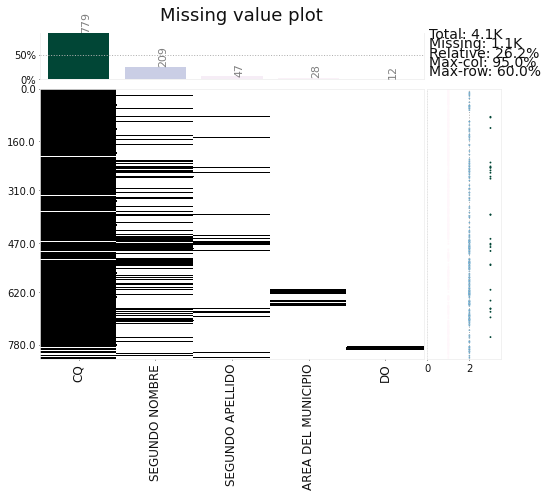

In [ ]:
#@title Handling Missing Data
klib.missingval_plot(pat_df, figsize=(8,6), sort=True)
pat_df['AREA DEL MUNICIPIO'] = pat_df['AREA DEL MUNICIPIO'].fillna(2) # En general los datos que faltaron correspondieron a zonas rurales
pat_df = pat_df.drop(['SEGUNDO NOMBRE', 'SEGUNDO APELLIDO','CQ'],axis=1)
#seleccionar pruebas faltantes:
no_data = pat_df.loc[(pat_df['RESULTADO PCR']=='NO LLEGO MUESTRA') |
                     (pat_df['RESULTADO PCR']=='NO LLEGO MUESTRA ') |
                     (pat_df['RESULTADO SEROLOGIA'] == 'NO LLEGO MUESTRA')|
                     (pat_df['RESULTADO SEROLOGIA'] == 'Pendiente')]
#Las eliminamos del set principal
pat_df = pat_df.drop(index=no_data.index)

Los datos faltantes son datos de identificación de la persona, como su segundo nombre y su segundo apellido, el area del municipio deonde vive, y los resultados de las pruebas CQ y DO.

Para el modelado, podemos descartar la prueba CQ, ya que tiene una tasa de datos faltantes cercana o mayor al 60%. Descartar o no las columnas correspondientes a identificadores es opcional. Las columnas correspondientes al **Area del municipio** y al **DO** pueden ser de utilidad para las clasificaciones y extracción de patrones.

### Data Pre-processing

En esta sección se hace una codificación de las variables categóricas, así como un mapeo de la sintomatología 2 (No presenta sintomas) a 0, para una interpretación más intuitiva y una posible mejora en el rendimiento del modelo.

La tabla mostrada es la descripción de las columnas luego del procesamiento. Podemos notar algunas diferencias con la obtenida en *Información Básica de los Datos.*

In [ ]:
#@title Funciones de reemplazo
def simple_encoding(data):
  #Utilizado para convertir el 2 negativo de la sintomatología, a 0.
  sintomas = ['SORDERA','VOMITOS','MAREOS, PERDIDA DE APETITO','FIEBRE,TOS,DOLOR EN EL CUERPO, PERDIDA DE OLFATO','TOS',
              'DIFICULTAD PARA RESPIRAR','DOLORES MUSCULARES Y CORPORALES','FIEBRE Ó ESCALOFRIOS','FATIGA',
              'DOLOR DE GARGANTA','DIARREA','NÁUSEAS O VÓMITOS','DOLOR DE CABEZA', 'PERDIDAD DEL OLFATO O DEL GUSTO',
              'CONGESTION DE LA NARIZ ', 'TOMA MEDICAMENTOS']
  data[sintomas] = data[sintomas].apply(lambda x: x.replace({2:0,3:float('nan')}),axis=1)
  
  data[sintomas] = data[sintomas].apply(pd.to_numeric,errors='coerce',axis=1)

  return data
def stringtonum(data):
        #organized in such way that follows the relationships

    pcr = data['RESULTADO PCR'].astype(object).replace({'NEGATIVO': 0, 'POSITIVO': 1})
    sero = data['RESULTADO SEROLOGIA'].astype(object).replace({'NEGATIVO': 0, 'POSITIVO':1})
    casa = data['CASA DE FAMILIARES'].astype(object).replace({'X':0})

    lugar = data['LUGAR DE RESIDENCIA'].astype(object).replace({'5':float('nan'),5:float('nan')})# el orden estaba bien, de menos a más aglomeración

    sgss = data['AFILIACION  AL SGSSS'].astype(object).replace({'5':float('nan'),5:float('nan')})# =

    otro = data['OTRO CUAL?'].astype(object).replace({'TRABAJO': 2,'BANCO':3,'EFECTY':3,'CLINICA':6,'DOMICILIOS':5,
                                        'VENDEDORA AMBULANTE DE TINTOS':5,'CASA DE LOS VECI2S':4,'2':0,'3':float('nan'),
                                        'PARCELA':2,'ENTIDAD QUE ENTREGA EL SUBSIDIO':3,
                                        'ALCALDIA':3, 'ESTACION, CASA':2})

    edad = data['EDAD'].astype(object).replace({'NO REGISTRA':float('nan')})
    utp = data['UTILIZA TRANSPORTE PUBLICO'].astype(object).replace({'S':4})

    data['RESULTADO PCR'] = pd.to_numeric(pcr)
    data['RESULTADO SEROLOGIA'] = pd.to_numeric(sero)
    data['CASA DE FAMILIARES'] = pd.to_numeric(casa)
    data['OTRO CUAL?'] = pd.to_numeric(otro)
    data['EDAD'] = pd.to_numeric(edad)
    data['UTILIZA TRANSPORTE PUBLICO'] = pd.to_numeric(utp)
    return data

pat_df = simple_encoding(pat_df)
pat_df = stringtonum(pat_df)
#Cambiar los espacios
pat_df.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)
pat_df.describe()

,AREA_DEL_MUNICIPIO,EDAD,SEXO,AFILIACION__AL_SGSSS,LUGAR_DE_RESIDENCIA,ESCOLARIDAD,TOMA_MEDICAMENTOS,FIEBRE_Ó_ESCALOFRIOS,TOS,DIFICULTAD_PARA_RESPIRAR,FATIGA,DOLORES_MUSCULARES_Y_CORPORALES,DOLOR_DE_CABEZA,PERDIDAD_DEL_OLFATO_O_DEL_GUSTO,DOLOR_DE_GARGANTA,CONGESTION_DE_LA_NARIZ_,NÁUSEAS_O_VÓMITOS,DIARREA,LA_PERSONA_CON_COVID_ESTUVO_AISLADA_DE_LOS_DEMAS?,ALGUIEN_COMPARTE_HABITACION,USAN_MEDIDAS_DE_PROTECCION_DENTRO_DE_LA_CASA,USAN_MASCARILLAS_O_CARETAS_DENTRO_DE_LA_VIVIENDA,DURANTE_LA_PANDEMIA_ME_HE_QUEDADO_EN_CASA,CUANDO_LLEGA_DE_LA_CALLE_SE_QUITA_Y_LAVA_LA_ROPA,SE_QUITA_LOS_ZAPATOS_O_LOS_DESINFECTA,UTILIZA_TRANSPORTE_PUBLICO,PARA_MOVILIZARSE_UTILIZA_ALGUN_ELEMENTO_DE_PROTECCIÓN,DE_LOS_ELEMENTOS_DE_PROTECCIÓN,DESINFECTO_TODOS_LOS_PAQUETES_QUE_LLEGAN,CASA_DE_FAMILIARES,TIENDA_,SUPERMERCADO,CENTRO_COMERCIAL,MERCADO,FARMACIA,CENTRO_DE_SALUD,PARQUE,OTRO_CUAL?,YO_CREO_QUE?,SOBRE_LA_DURACIÓN?,ESTARÍA_DISPUESTO_A_VACUNARME?,DURANTE_EL_AISLAMIENTO_OBLIGATORIO_ME_HE_SENTIDO?,CAMBIÉ_MIS_HÁBITOS_ALIMENTICIOS,AUMENTE_DE_PESO,VEO_MÁS_TV,SENTÍ_TEMOR_DE_SALIR_DE_LA_CASA,ME_HABRIA_AISLADO_VOLUNTARIAMENTE,PERDÍ_MI_TRABAJO,RECIBO_AYUDA_DEL_ESTADO,FORTALECÍ_MI_RELACIÓN_CON_MI_FAMILIA,ESTUVE_DE_ACUERDO_CON_LAS_MEDIDAS_DEL_GOBIER2,HE_CAMBIADO_DE_ACTIVIDAD_LABORAL?,¿LA_COVID_-19_ES?,"FIEBRE,TOS,DOLOR_EN_EL_CUERPO,_PERDIDA_DE_OLFATO","MAREOS,_PERDIDA_DE_APETITO",VOMITOS,SORDERA,EL_MAYOR_RIESGO_LO_TIENEN,EL_VIRUS_SE_TRANSMITE_POR_EL_AIRE,SE_TRANSMITE_POR_TOCAR_SUPERFICIES_EN_LA_CALLE,SI_ME_ENFERMO_QUE_DEBO_HACER?,AISLAMIENTO,USO_DE_TAPABOCAS,DISTANCIAMIENTO_SOCIAL,RESULTADO_SEROLOGIA,RESULTADO_PCR,SINTOMAS,lat,lon
count,796.000000,777.000000,796.000000,796.000000,796.000000,796.000000,769.000000,783.000000,784.000000,784.000000,784.000000,784.000000,784.000000,784.000000,784.000000,784.000000,784.000000,781.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,692.000000,710.000000,711.000000,708.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000
mean,1.359296,41.729730,1.503769,1.690955,1.417085,4.841709,0.247074,0.200511,0.155612,0.091837,0.072704,0.196429,0.233418,0.140306,0.158163,0.127551,0.073980,0.088348,3.383166,3.448492,3.354271,3.405779,2.483668,1.265075,1.550251,1.785176,1.412060,1.330402,1.708543,1.646985,1.654523,1.782663,1.991206,1.949749,1.959799,1.924623,2.013819,2.246231,1.327889,1.940955,2.043970,4.248744,2.021357,1.732412,1.987437,1.858040,2.076633,1.922111,1.762563,1.234925,1.447236,1.932161,1.321608,0.302023,0.264789,0.234880,0.700565,3.023869,1.479899,1.184673,1.435930,1.554020,1.242462,1.334171,0.429648,0.043970,0.031407,8.606641,-75.640701
std,0.515473,16.611589,0.500300,0.786662,0.874177,2.128588,0.431591,0.400639,0.362719,0.288980,0.259816,0.397550,0.423276,0.347526,0.365127,0.333802,0.261905,0.283983,1.133889,0.994885,1.162353,1.107966,1.384000,0.766491,0.949671,0.612516,0.869355,0.750768,0.988221,0.578224,0.569667,0.518101,0.326865,0.385247,0.369793,0.409751,0.294281,0.472833,0.792592,1.112663,1.266631,2.247780,0.927997,0.653971,1.017998,1.003741,1.376499,0.474734,0.535676,0.536784,0.847329,0.658125,0.616001,0.459467,0.441532,0.424223,0.458334,0.302082,0.596297,0.540036,0.958072,0.514784,0.446094,0.487724,0.495337,0.205157,0.174525,0.449457,0.235781
min,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000

Tengamos en cuenta:

1. El primer nombre, el apellido, y el telefono los serán descartados del set de datos.
2. Usaremos para el analisis exploratorio un modelo XGBoost, ya que este trata con los Nan (valores nulos o no validos), las categorías y los objetos sin problemas, es un modelo robusto, y nos puede indicar qué características son las más influyentes para la predicción.
3. Para el modelado es una buena practica quitar los espacios de los nombres de las caracteristicas.







In [ ]:
#@title Eliminación de Identidad
ready_df = pat_df.drop(['PRIMER_NOMBRE','PRIMER_APELLIDO','TELEFONO','DO','DIRECCIÓN'],axis=1)

### Feature Engineering

En esta sección se crean características que pueden ser útiles para el modelado, ente estas se encuentran relaciones (divisiones) entre síntomas, investigación en fuentes externas (PIB, IDH, Población de la ciudad), entre otras. 

Características como el ratio de infección cabeza/cuerpo o el PIB de su departamento dividido entre la población pueden ser de interés.

In [ ]:
#@title Incluir PIB, Población, Área del municipio y otros
%%capture
ready_df['PIB'] = 0
ready_df['PIB'].loc[ready_df['MUNICIPIO']=='Lorica'] = 1059 #está en miles de millones de pesos
ready_df['PIB'].loc[ready_df['MUNICIPIO']=='Planeta Rica'] = 507
ready_df['PIB'].loc[ready_df['MUNICIPIO']=='Tierralta'] = 1092
ready_df['PIB'].loc[ready_df['MUNICIPIO']=='Sahagun'] = 810
ready_df['PIB'].loc[ready_df['MUNICIPIO']=='Montelibano'] = 1793

ready_df['POBLACION'] = 0
ready_df['POBLACION'].loc[ready_df['MUNICIPIO']=='Lorica'] = 64776
ready_df['POBLACION'].loc[ready_df['MUNICIPIO']=='Planeta Rica'] = 115461 #Población total
ready_df['POBLACION'].loc[ready_df['MUNICIPIO']=='Tierralta'] = 95177
ready_df['POBLACION'].loc[ready_df['MUNICIPIO']=='Sahagun'] = 110233
ready_df['POBLACION'].loc[ready_df['MUNICIPIO']=='Montelibano'] = 85885

ready_df['AREA'] = 0
ready_df['AREA'].loc[ready_df['MUNICIPIO']=='Lorica'] = 1033 #Area total
ready_df['AREA'].loc[ready_df['MUNICIPIO']=='Planeta Rica'] = 1148
ready_df['AREA'].loc[ready_df['MUNICIPIO']=='Tierralta'] = 5025
ready_df['AREA'].loc[ready_df['MUNICIPIO']=='Sahagun'] = 992
ready_df['AREA'].loc[ready_df['MUNICIPIO']=='Montelibano'] = 1820

ready_df['DENSIDAD_POBLACIONAL'] = ready_df['POBLACION']/ready_df['AREA']
ready_df['INGRESOS_POR_HABITANTE'] = ready_df['PIB']/ready_df['POBLACION']

El PIB, la población, y el tamaño del municipio pueden dar cierta noción del desarrollo y las condiciones en éste. Variables como Densidad poblacional (Población/Area), o Ingresos por habitante (PIB/Población), también pueden ser de utilidad por la información socioeconómica que aportan.

In [ ]:
#@title Tabla Socioeconómica por Municipios
ready_df[['PIB','POBLACION','AREA','DENSIDAD_POBLACIONAL','INGRESOS_POR_HABITANTE','MUNICIPIO']].groupby(['MUNICIPIO']).max()

,PIB,POBLACION,AREA,DENSIDAD_POBLACIONAL,INGRESOS_POR_HABITANTE
MUNICIPIO,,,,,
Lorica,1059,64776,1033,62.706680,0.016349
Montelibano,1793,85885,1820,47.189560,0.020877
Planeta Rica,507,115461,1148,100.575784,0.004391
Sahagun,810,110233,992,111.121976,0.007348
Tierralta,1092,95177,5025,18.940697,0.011473


Además podemos jugar con las variables que ya tenemos, personalizada por paciente, y crear unas adicionales.

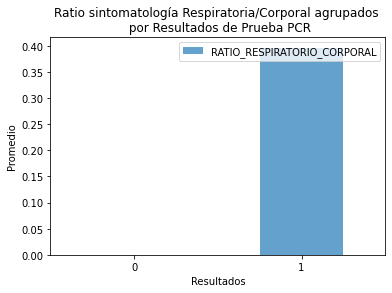

In [ ]:
#@title Ratio Respiratorio/Corporal
ready_df = ready_df.fillna(0)
ready_df['RATIO_RESPIRATORIO_CORPORAL'] = (ready_df['FIEBRE,TOS,DOLOR_EN_EL_CUERPO,_PERDIDA_DE_OLFATO']+ready_df['TOS']+ready_df['DIFICULTAD_PARA_RESPIRAR']+
                                           ready_df['DOLOR_DE_GARGANTA'])/(ready_df['SORDERA']+ready_df['VOMITOS']+ready_df['MAREOS,_PERDIDA_DE_APETITO']+
                                           ready_df['FIEBRE,TOS,DOLOR_EN_EL_CUERPO,_PERDIDA_DE_OLFATO']+ready_df['DOLORES_MUSCULARES_Y_CORPORALES']+
                                           ready_df['FIEBRE_Ó_ESCALOFRIOS']+ready_df['FATIGA']+ready_df['DOLOR_DE_GARGANTA']+ready_df['DIARREA']+
                                           ready_df['NÁUSEAS_O_VÓMITOS'])
ready_df[['RATIO_RESPIRATORIO_CORPORAL','RESULTADO_PCR']].groupby(['RESULTADO_PCR']).mean().plot(kind='bar',title='Ratio sintomatología Respiratoria/Corporal agrupados \n por Resultados de Prueba PCR',ylabel='Promedio',xlabel='Resultados',rot=0,alpha=0.75,colormap='tab20c')                                           

Esta relación busca comprobar si los sintomas asociados al sistema respiratorio hacen que sea más probable una prueba PCR positiva. Entre mayor el ratio, mayor la sintomatología respiratoria, si la sintomatología respiratoria es nula, la relación es 0.

In [ ]:
#@title Guardar o cargar datos Pre-procesados
try:
  ready_df.to_csv('/content/drive/MyDrive/Covid UC/Patients_for_analysis_&_modelling.csv')
except:
  ready_df=pd.read_csv('/content/drive/MyDrive/Covid UC/Patients_with_coordinates_for_analysis_&_modelling.csv')

### Gráficos

Estudiando el COVID-19, suponemos que hay unas características que son más influyentes que otras. La edad, el municipio, lugar frecuentado, sintomas de tos, disposición a vacunarse, etc, son ejemplos de caracterísitcas relevantes.

A continuación analizaremos estas características con mayor detenimiento.

In [ ]:
#@title Función para graficar apilados
def apilado(datos, target, agrupacion, height=20, base=14,b=None,fsize=10,k='bar',fil=0,col=0,rotation=0,stk=False,x_vals=None):

  conteo_total = datos[[target,agrupacion]].groupby([agrupacion]).count()
  positivos = datos[[target,agrupacion]].loc[datos[target]==1].groupby([agrupacion]).count()
  negativos = datos[[target,agrupacion]].loc[datos[target]==0].groupby([agrupacion]).count()

  positivos = 100*positivos/conteo_total
  negativos = 100*negativos/conteo_total

  positivos.rename(columns={target: 'Positivos'}, inplace=True)
  negativos.rename(columns={target: 'Negativos'}, inplace=True)
  
  try:
    pd.concat([positivos, negativos],axis = 1).plot(kind=k,x=x_vals,stacked=stk,ax=axs[fil,col],figsize=(height,base), fontsize=fsize,alpha=0.75,rot=rotation, title='Porcentaje '+ target+' vs '+ agrupacion, ylabel='Porcentaje',colormap='tab20c')
  except:
    pd.concat([positivos, negativos],axis = 1).plot(kind=k,x=x_vals,stacked=stk,figsize=(height,base), fontsize=fsize,alpha=0.75,rot=rotation, title='Porcentaje '+ target+' vs '+ agrupacion, ylabel='Porcentaje',colormap='tab20c')


In [ ]:
#@title Preparación de los Datos para el Análisis

ready_df['SOBRE_LA_DURACIÓN?'] = ready_df['SOBRE_LA_DURACIÓN?'].astype(object).replace({1: 'Durará hasta que\n salga la vacuna',
                                                                                      2: 'Esta por terminarse',
                                                                                      3: 'Vino para quedarse',
                                                                                      4: 'Sin Dato',
                                                                                      5: 'Ya se terminó'})
ready_df['DURANTE_LA_PANDEMIA_ME_HE_QUEDADO_EN_CASA'] = ready_df['DURANTE_LA_PANDEMIA_ME_HE_QUEDADO_EN_CASA'].astype(object).replace({1: 'Siempre',
                                                                                  2: 'Solo algunas veces',
                                                                                  3: 'Salgo cada vez que puedo',
                                                                                  4: 'Salgo a trabajar',
                                                                                  5: 'Sin Dato'})
ready_df['ESTARÍA_DISPUESTO_A_VACUNARME?'] = ready_df['ESTARÍA_DISPUESTO_A_VACUNARME?'].astype(object).replace({1: 'Siempre',
                                                                                    2: 'Solo si es segura',
                                                                                    3: 'Solo si me obligan',
                                                                                    4: 'No me vacunaría',
                                                                                    5: 'Sin dato'})



Estos gráficos nos ofrecen información sobre la distribución de resultados según algunas variables seleccionadas. En su mayoría son negativos, pero tomando como ejemplo el *Porcentaje de Resultados vs Municipio*, vemos que en Sahagún hay un Porcentaje de casos positivos claramente mayor al resto de municipios.

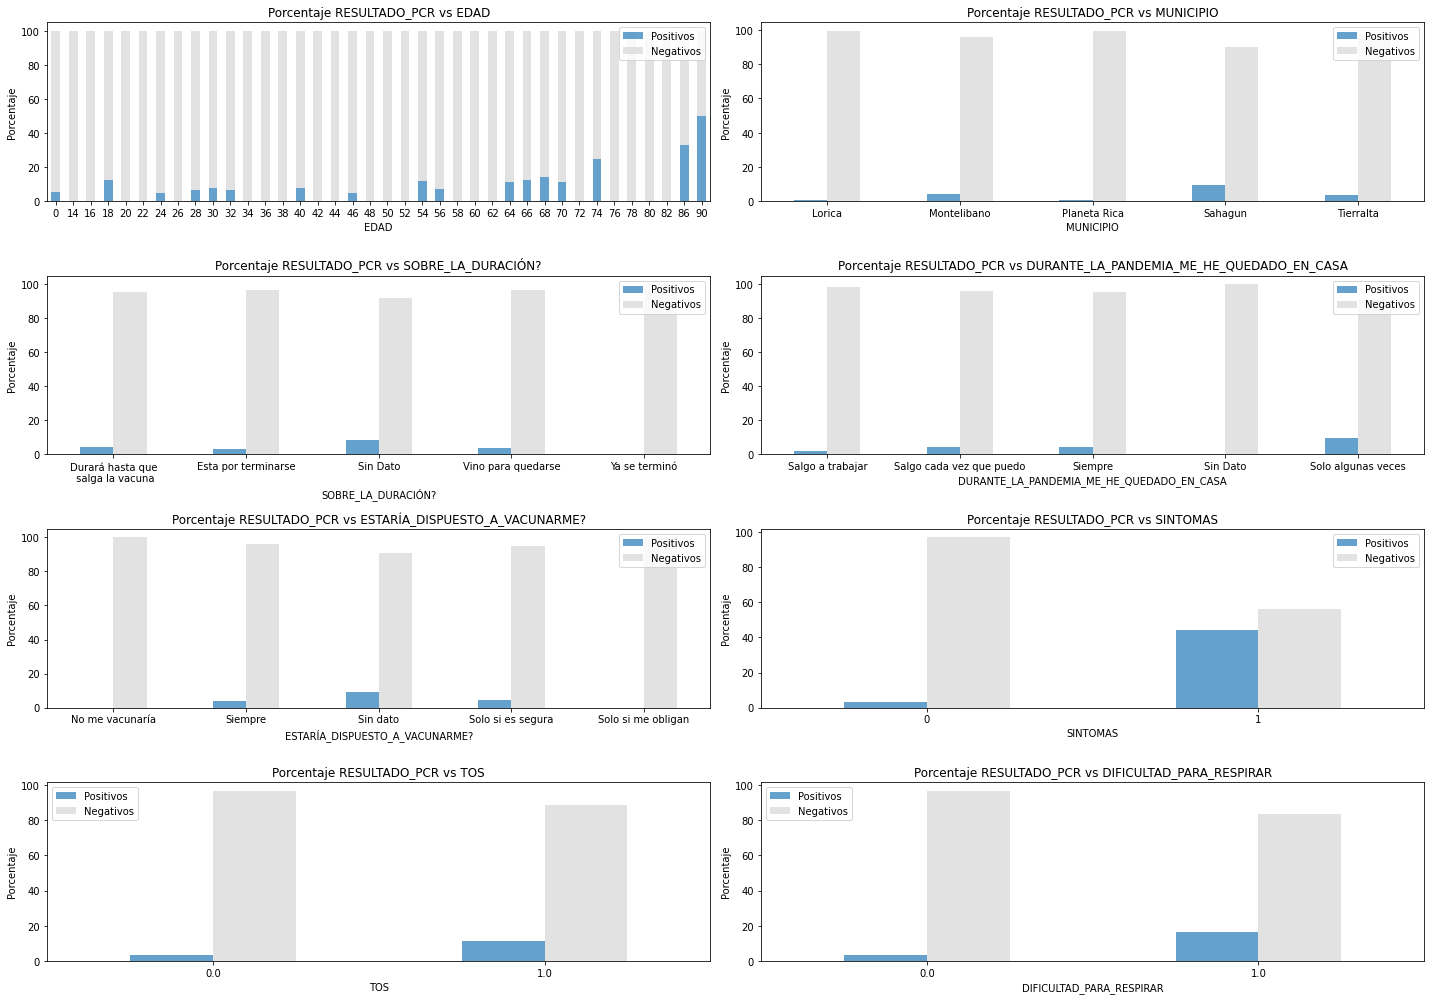

In [ ]:
#@title #### Gráficos Apilados Relacionados a la PCR
fig, axs = plt.subplots(4, 2)#filas columnas
ready_df['EDAD'] = ready_df['EDAD'].astype(int)
apilado(ready_df[ready_df['EDAD']%2==0],'RESULTADO_PCR','EDAD',stk=True,fil=0,col=0)
apilado(ready_df,'RESULTADO_PCR','MUNICIPIO',fil=0,col=1)
apilado(ready_df,'RESULTADO_PCR','SOBRE_LA_DURACIÓN?',fil=1,col=0)
apilado(ready_df,'RESULTADO_PCR','DURANTE_LA_PANDEMIA_ME_HE_QUEDADO_EN_CASA',fil=1,col=1)
apilado(ready_df,'RESULTADO_PCR','ESTARÍA_DISPUESTO_A_VACUNARME?',fil=2,col=0)
apilado(ready_df,'RESULTADO_PCR','SINTOMAS',fil=2,col=1)
apilado(ready_df,'RESULTADO_PCR','TOS',fil=3,col=0)
apilado(ready_df,'RESULTADO_PCR','DIFICULTAD_PARA_RESPIRAR',fil=3,col=1)
fig.tight_layout() #imprta el orden


Para la convención de sintomas.

0.  No
1.  Sí


No hay conclusiones claras acerca de como las variables de pensamiento y entorno influyen en el resultado de la prueba, pero puede que una relación entre éstas sí.

Al parecer, que una persona **no** presente dificultad para respirar, hace que sea mucho más probable un **resultado negativo** de PCR.

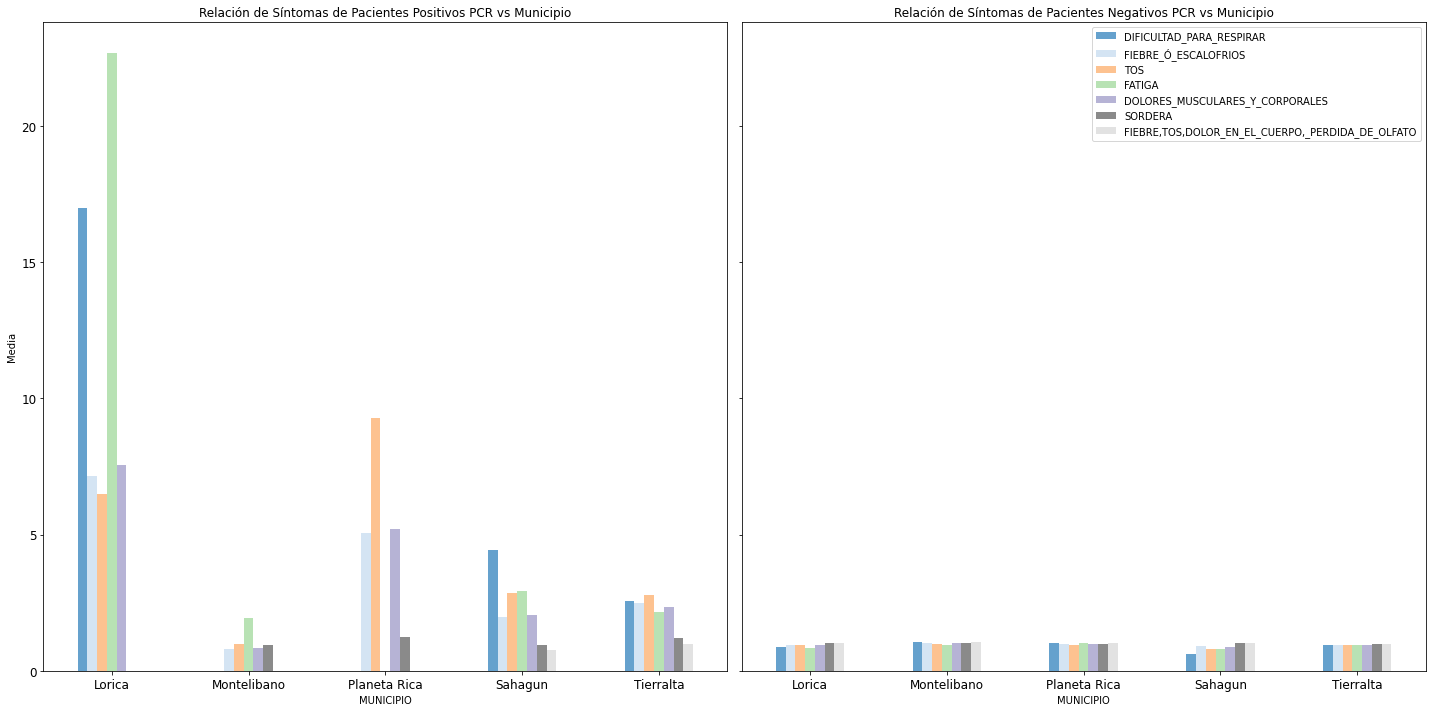

In [ ]:
#@title Relación de Síntomas por Municipio
#deben ser positivos en la prueba de PCR, si contamos también los negativos, el promedio baja
fig, axs = plt.subplots(1, 2,sharey=True)#filas columnas
# (ready_df[['VOMITOS','DIFICULTAD_PARA_RESPIRAR','FIEBRE_Ó_ESCALOFRIOS','TOS','FATIGA','MAREOS,_PERDIDA_DE_APETITO','DOLORES_MUSCULARES_Y_CORPORALES','SORDERA','FIEBRE,TOS,DOLOR_EN_EL_CUERPO,_PERDIDA_DE_OLFATO','MUNICIPIO']].loc[ready_df['RESULTADO_PCR']==1].groupby(['MUNICIPIO']).mean()*100).plot(kind='bar',ax=axs[0],figsize=(12,10),title='Síntomas de Pacientes Positivos PCR vs Municipio',colormap='tab20c')
total = (ready_df[['DIFICULTAD_PARA_RESPIRAR','FIEBRE_Ó_ESCALOFRIOS','TOS','FATIGA','DOLORES_MUSCULARES_Y_CORPORALES','SORDERA','FIEBRE,TOS,DOLOR_EN_EL_CUERPO,_PERDIDA_DE_OLFATO','MUNICIPIO']].groupby(['MUNICIPIO']).mean())
positivos = (ready_df[['DIFICULTAD_PARA_RESPIRAR','FIEBRE_Ó_ESCALOFRIOS','TOS','FATIGA','DOLORES_MUSCULARES_Y_CORPORALES','SORDERA','FIEBRE,TOS,DOLOR_EN_EL_CUERPO,_PERDIDA_DE_OLFATO','MUNICIPIO']].loc[ready_df['RESULTADO_PCR']==1].groupby(['MUNICIPIO']).mean())
positivos = positivos/total
positivos.plot(kind='bar',ax=axs[0],figsize=(20,10),fontsize=12,title='Relación de Síntomas de Pacientes Positivos PCR vs Municipio',colormap='tab20c',legend=None,rot=0,alpha=0.75,ylabel='Media')

negativos = (ready_df[['DIFICULTAD_PARA_RESPIRAR','FIEBRE_Ó_ESCALOFRIOS','TOS','FATIGA','DOLORES_MUSCULARES_Y_CORPORALES','SORDERA','FIEBRE,TOS,DOLOR_EN_EL_CUERPO,_PERDIDA_DE_OLFATO','MUNICIPIO']].loc[ready_df['RESULTADO_PCR']==0].groupby(['MUNICIPIO']).mean())
negativos = negativos/total
negativos.plot(kind='bar',ax=axs[1],figsize=(20,10),fontsize=12,title='Relación de Síntomas de Pacientes Negativos PCR vs Municipio',colormap='tab20c',rot=0,alpha=0.75)
fig.tight_layout() #imprta el orden


Una posible causa de la gravedad de los casos, o de la gran tasa de contagios en un municipio, podrían ser los síntomas que presentan los infectados del lugar, ya que hay unos síntomas que facilitan más la propagación que otros.

Podemos ver que dependiendo del municipio, los pacientes positivos tuvieron en promedio una sintomatología distinta. (El conteo de pacientes por municipio es diferente, así que un submuestreo podría estar implicito)

Las personas en Montelíbano son las que mostraron la menor relación de síntomas, siendo la sintomatología prácticamente nula.

A partir de ésta comparativa queda pendiente averiguar **qué** es lo que está causando la sordera en los casos negativos, ya que es algo recurrente. 

En general la fiebre, la tos, o la dificultad para respirar fueron síntomas más comunes entre los casos positivos.

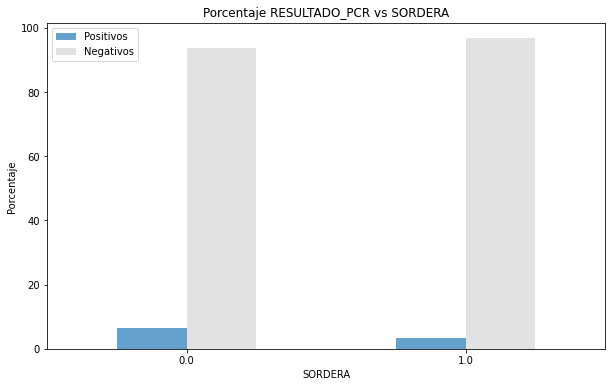

In [ ]:
apilado(ready_df,'RESULTADO_PCR','SORDERA',height=10,base=6)

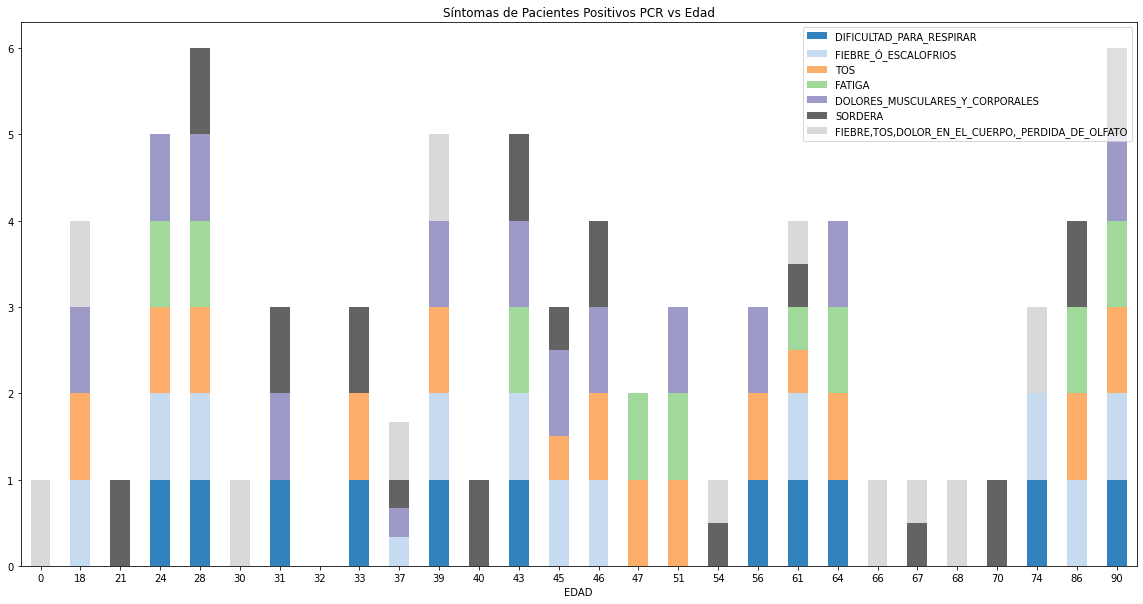

In [ ]:
#@title Síntomas vs Edad
ready_df[['DIFICULTAD_PARA_RESPIRAR','FIEBRE_Ó_ESCALOFRIOS','TOS','FATIGA','DOLORES_MUSCULARES_Y_CORPORALES','SORDERA','FIEBRE,TOS,DOLOR_EN_EL_CUERPO,_PERDIDA_DE_OLFATO','EDAD']].loc[ready_df['RESULTADO_PCR']==1].groupby(['EDAD']).mean().plot(kind='bar',stacked=True,figsize=(20,10),title='Síntomas de Pacientes Positivos PCR vs Edad',colormap='tab20c',rot=0)

Sabemos que dependiendo de la Edad, la persona suele tener una respuesta inmune diferente, por lo que la sintomatología podría verse afectada. Veamos si hay una relación entre la edad de la persona y los sintomas que presenta.

Podemos ver que la sintomatología **aparentemente** se encuentra distribuida en todos los rangos de edad sin discriminación, por lo que la hipotesis se podría ser **Falsa**.

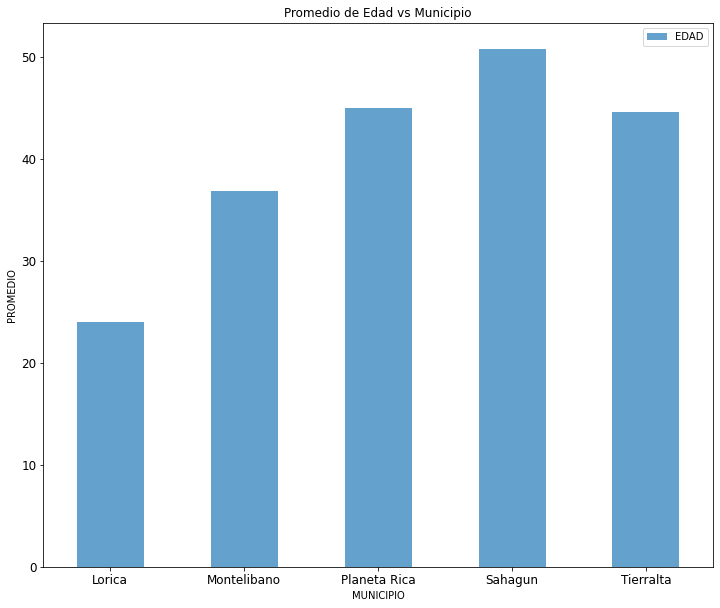

In [ ]:
#@title Edad vs Municipio
ready_df[['EDAD','MUNICIPIO']].loc[ready_df['RESULTADO_PCR']==1].groupby(['MUNICIPIO']).mean().plot(kind='bar',figsize=(12,10),fontsize=12,title='Promedio de Edad vs Municipio',colormap='tab20c',alpha=0.75,rot=0,ylabel='PROMEDIO')

No se encuentra una clara distinción entre las edades promedio de cada municipio, Planeta Rica, Tierralta y Sahagún presentan los pacientes con mayor promedio de edad, pero aún así la sintomatología fue muy diferente.

Con esto descartamos una relación de la edad con la sintomatología.



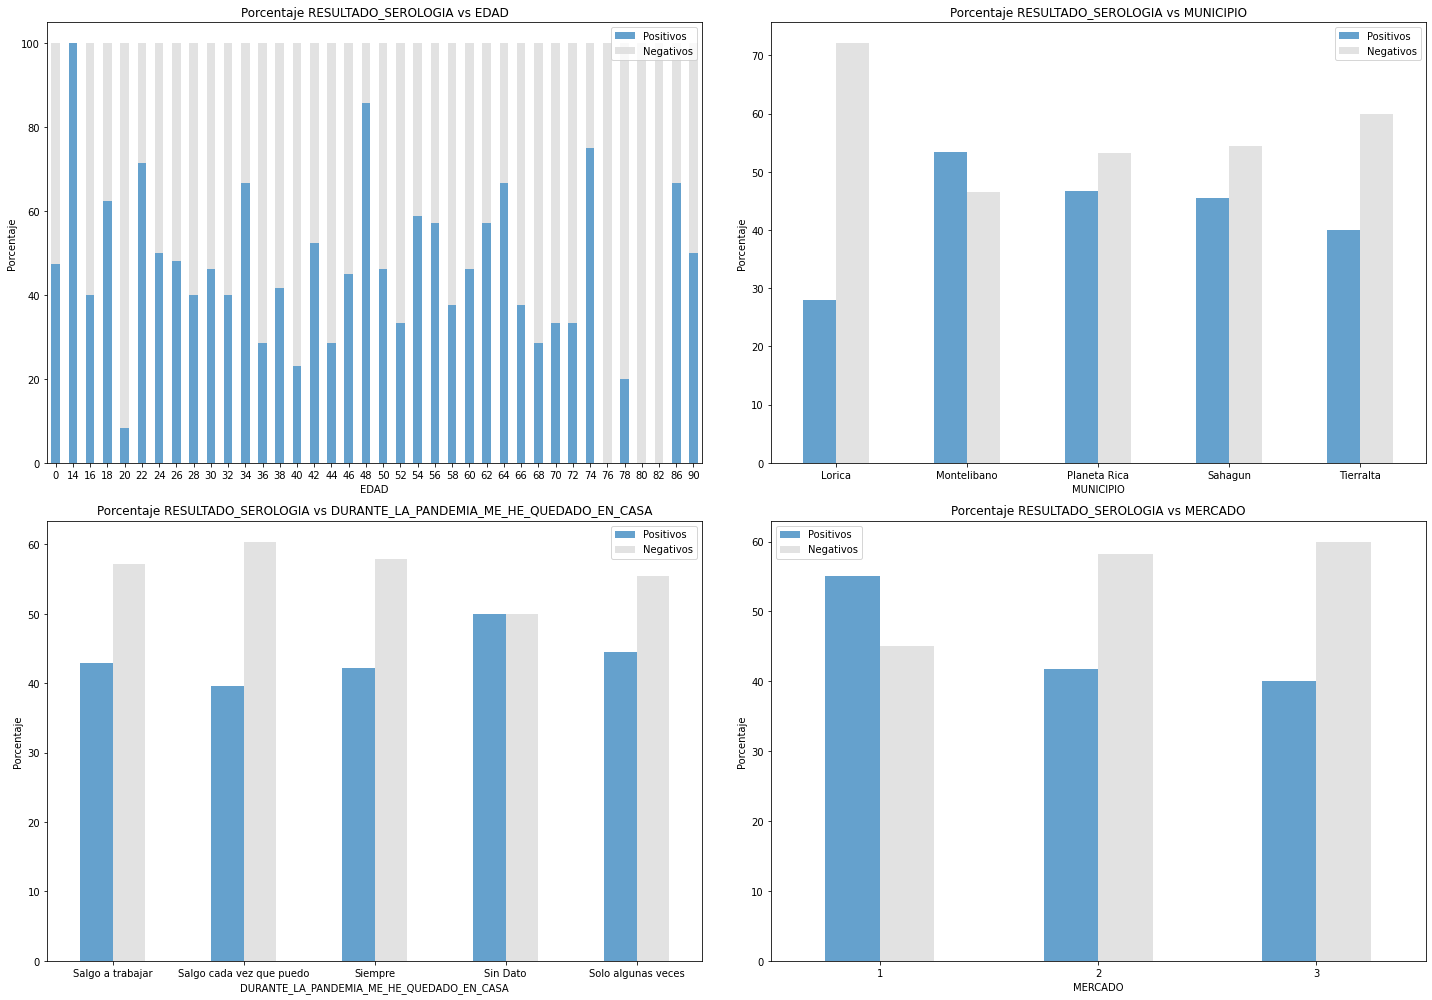

In [ ]:
#@title Análisis Serológico
fig, axs = plt.subplots(2,2)
apilado(ready_df[ready_df['EDAD']%2==0],'RESULTADO_SEROLOGIA','EDAD',stk=True,fil=0,col=0)
apilado(ready_df,'RESULTADO_SEROLOGIA','MUNICIPIO',fil=0,col=1)
apilado(ready_df,'RESULTADO_SEROLOGIA','DURANTE_LA_PANDEMIA_ME_HE_QUEDADO_EN_CASA',fil=1,col=0)
apilado(ready_df,'RESULTADO_SEROLOGIA','MERCADO',fil=1,col=1)
fig.tight_layout()

1. Sí.
2. No.
3. Sin Dato.


Las personas que son positivas en la prueba de serología, es porque estuvieron contagiadas en el pasado.


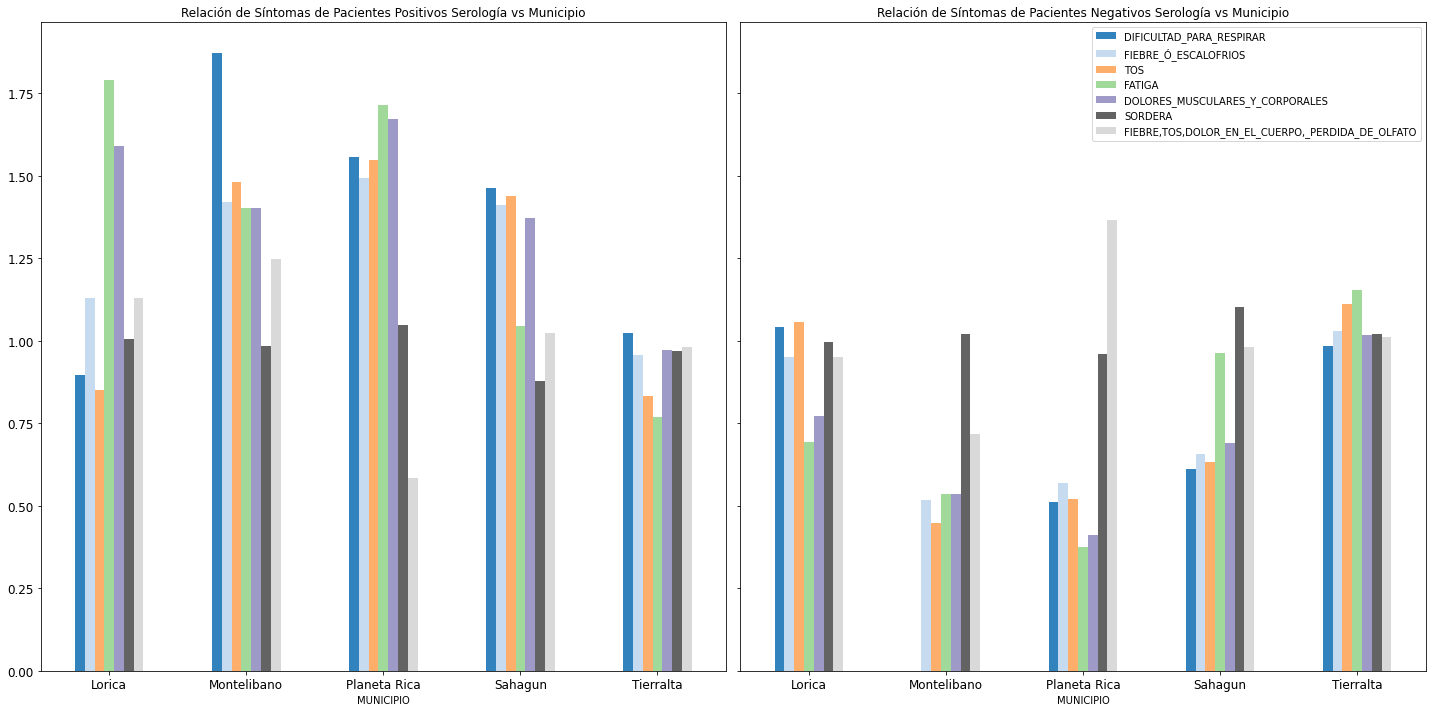

In [ ]:
#@title Relación de Sintomas de Pacientes por Municipio
fig, axs =plt.subplots(1,2,sharey=True)
total = ready_df[['DIFICULTAD_PARA_RESPIRAR','FIEBRE_Ó_ESCALOFRIOS','TOS','FATIGA','DOLORES_MUSCULARES_Y_CORPORALES','SORDERA','FIEBRE,TOS,DOLOR_EN_EL_CUERPO,_PERDIDA_DE_OLFATO','MUNICIPIO']].groupby(['MUNICIPIO']).mean()
positivo = (ready_df[['DIFICULTAD_PARA_RESPIRAR','FIEBRE_Ó_ESCALOFRIOS','TOS','FATIGA','DOLORES_MUSCULARES_Y_CORPORALES','SORDERA','FIEBRE,TOS,DOLOR_EN_EL_CUERPO,_PERDIDA_DE_OLFATO','MUNICIPIO']].loc[ready_df['RESULTADO_SEROLOGIA']==1].groupby(['MUNICIPIO']).mean())
positivo = positivo/total
positivo.plot(kind='bar',ax=axs[0],figsize=(20,10),title='Relación de Síntomas de Pacientes Positivos Serología vs Municipio',colormap='tab20c',legend=None,rot=0,fontsize=12)

negativo = (ready_df[['DIFICULTAD_PARA_RESPIRAR','FIEBRE_Ó_ESCALOFRIOS','TOS','FATIGA','DOLORES_MUSCULARES_Y_CORPORALES','SORDERA','FIEBRE,TOS,DOLOR_EN_EL_CUERPO,_PERDIDA_DE_OLFATO','MUNICIPIO']].loc[ready_df['RESULTADO_SEROLOGIA']==0].groupby(['MUNICIPIO']).mean())
negativo = negativo/total
negativo.plot(kind='bar',ax=axs[1],figsize=(20,10),title='Relación de Síntomas de Pacientes Negativos Serología vs Municipio',colormap='tab20c',rot=0,fontsize=12)
fig.tight_layout()

Observamos que no hay diferencias particulares en la sintomatología de casos positivos o negativos, por lo que la hipotesis de que hayan secuelas debido al covid no puede ser afirmada. 

Las pequeñas diferencias pueden ser debido a pruebas positivas de Serología de personas reincidentes o que ya están terminando la etapa de enfermedad.

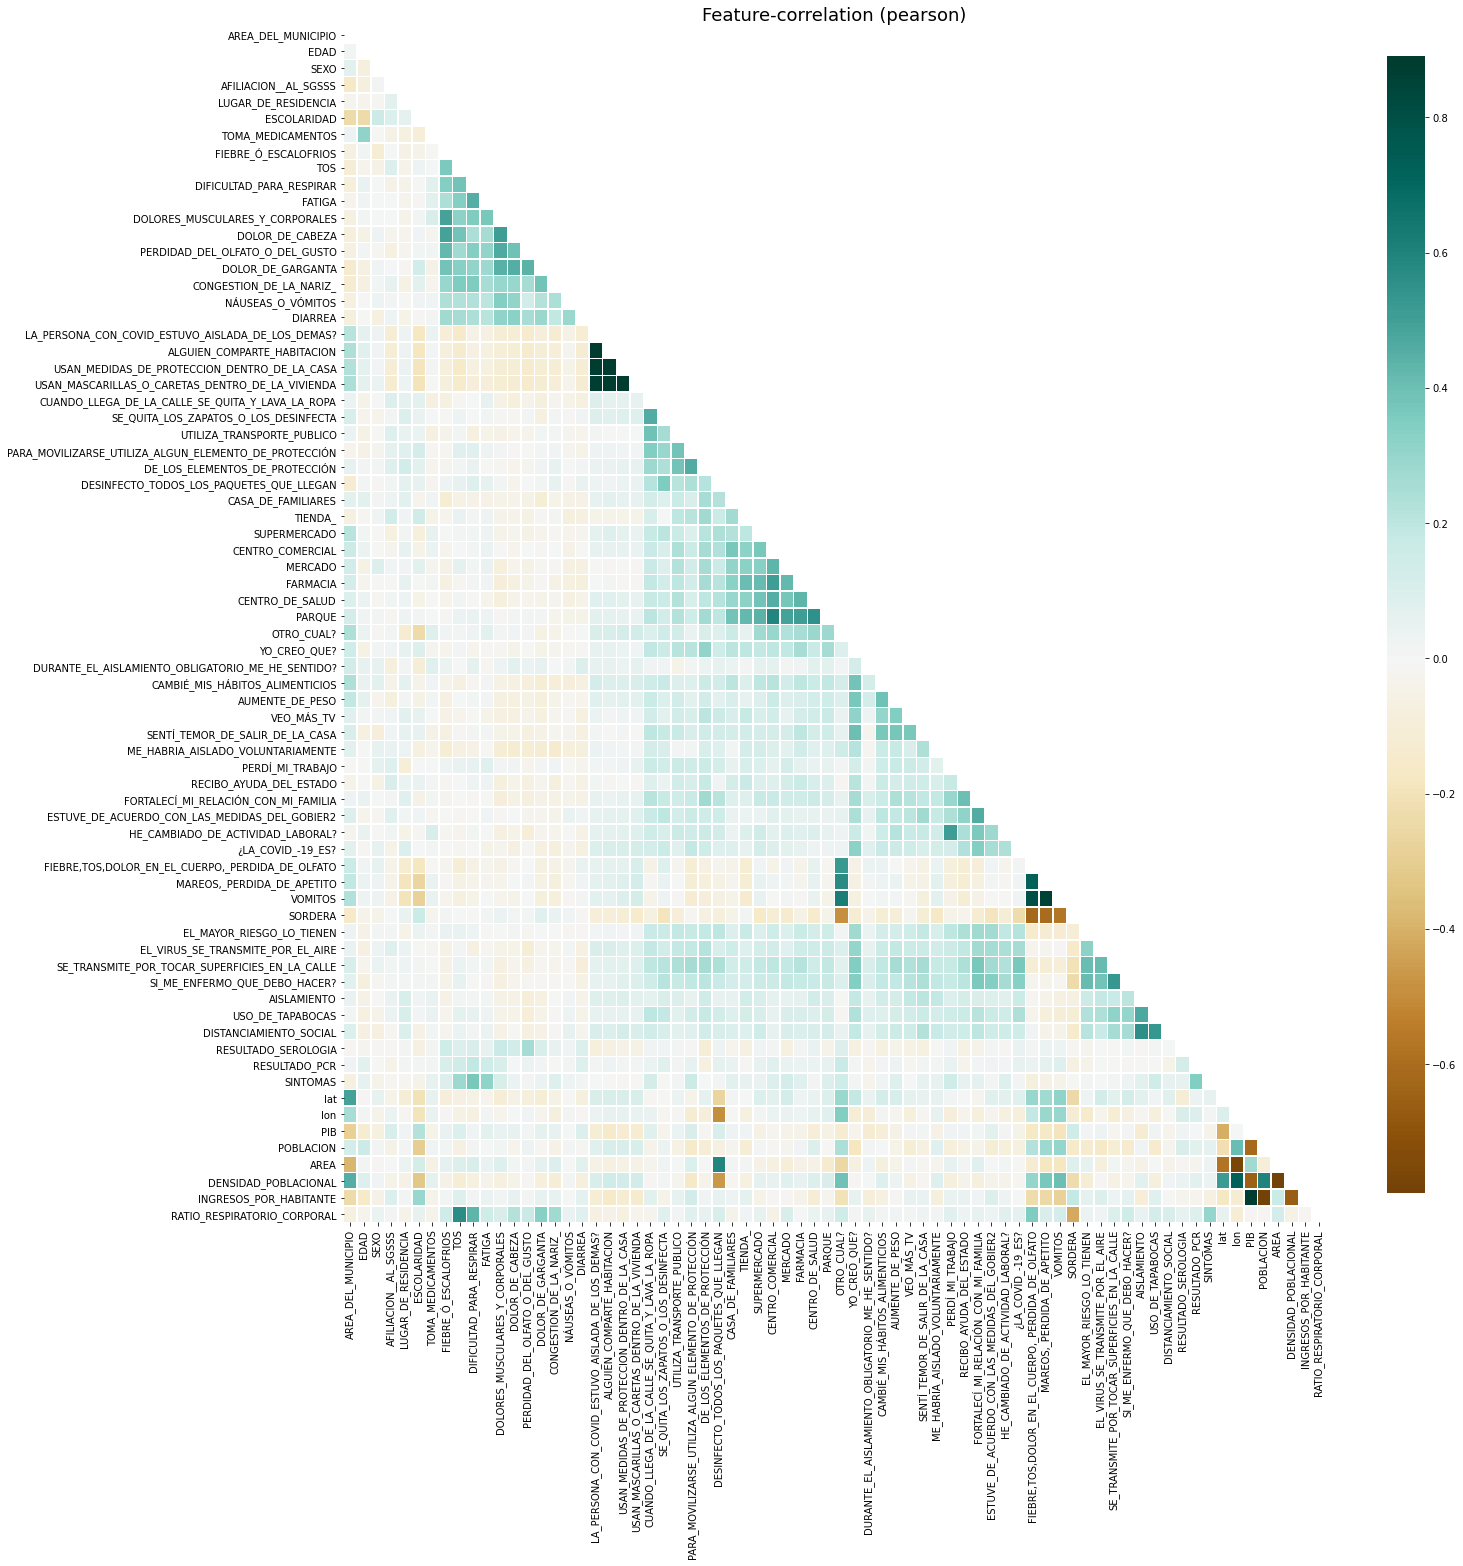

In [ ]:
#@title Análisis de Correlaciones
klib.corr_plot(ready_df,annot=False,figsize=(22,22))

Podemos hacer un análisis de las correlaciones entre las variables. Antes de proceder al modelado exploratorio.

In [ ]:
#@title ##### Conteo de Síntomas según OTRO CUAL?
ready_df[['OTRO_CUAL?','FIEBRE,TOS,DOLOR_EN_EL_CUERPO,_PERDIDA_DE_OLFATO','MAREOS,_PERDIDA_DE_APETITO','VOMITOS','SORDERA']].groupby('OTRO_CUAL?').count()

,"FIEBRE,TOS,DOLOR_EN_EL_CUERPO,_PERDIDA_DE_OLFATO","MAREOS,_PERDIDA_DE_APETITO",VOMITOS,SORDERA
OTRO_CUAL?,,,,
1,2,2,2,2
2,604,604,604,604
3,186,186,186,186
4,1,1,1,1
5,2,2,2,2
6,1,1,1,1


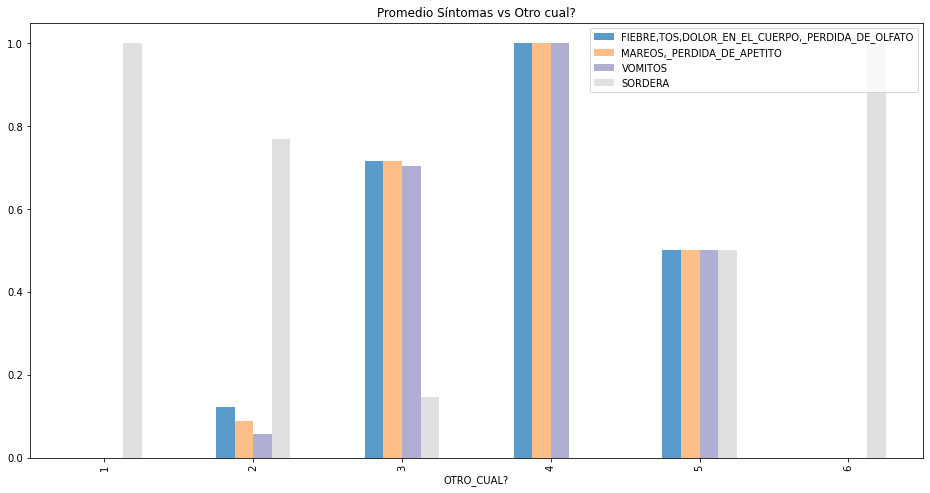

In [ ]:
#@title ##### Promedio de Síntomas según OTRO CUAL?
ready_df[['OTRO_CUAL?','FIEBRE,TOS,DOLOR_EN_EL_CUERPO,_PERDIDA_DE_OLFATO','MAREOS,_PERDIDA_DE_APETITO','VOMITOS','SORDERA']].groupby('OTRO_CUAL?').mean().plot(kind='bar',figsize=(16,8),title='Promedio Síntomas vs Otro cual?',colormap='tab20c',alpha=0.8)

Hay una aparente relación entre los síntomas y la característica OTRO_CUAL?, ya que algunos valores de ésta presentan unicamente sordera, y otros, presentan casi todos los síntomas a la par. Ésto puede deberse a la baja cantidad de valores distintos a 2 y a 3 en la variable OTRO_CUAL?.

Ésta característica requiere un análisis más profundo, porque ha demostrado ser importante, y no tenemos mucha documentación sobre ella.

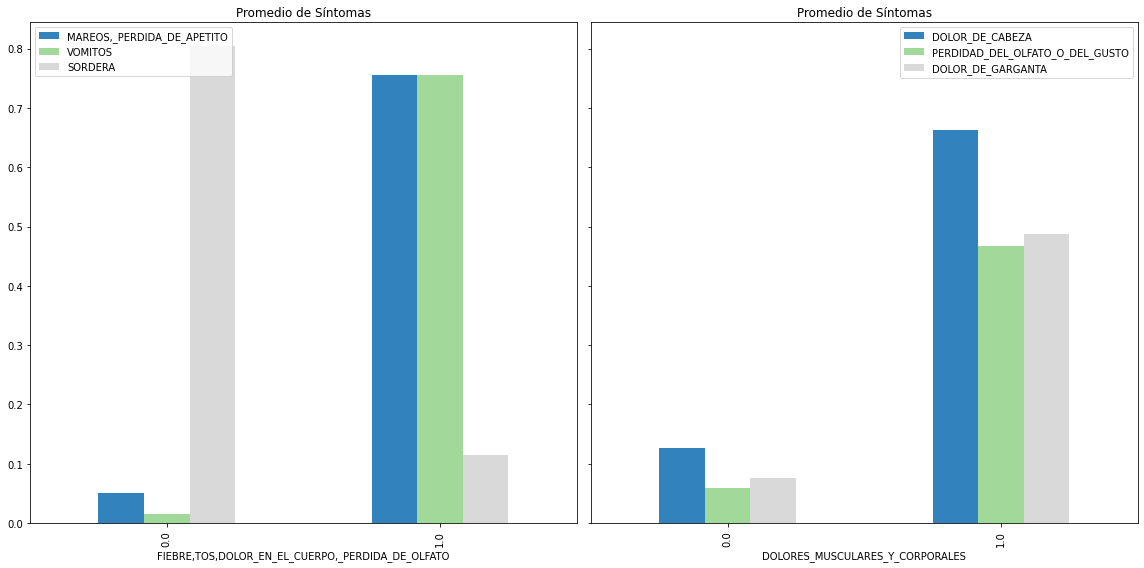

In [ ]:
#@title Relación entre Síntomas
fig, axs = plt.subplots(1,2,sharey=True)
ready_df[['FIEBRE,TOS,DOLOR_EN_EL_CUERPO,_PERDIDA_DE_OLFATO','MAREOS,_PERDIDA_DE_APETITO','VOMITOS','SORDERA']].groupby('FIEBRE,TOS,DOLOR_EN_EL_CUERPO,_PERDIDA_DE_OLFATO').mean().plot(title='Promedio de Síntomas',kind='bar',figsize=(10,6),colormap='tab20c',ax=axs[0])
ready_df[['DOLOR_DE_CABEZA','PERDIDAD_DEL_OLFATO_O_DEL_GUSTO','DOLOR_DE_GARGANTA','DOLORES_MUSCULARES_Y_CORPORALES']].groupby('DOLORES_MUSCULARES_Y_CORPORALES').mean().plot(kind='bar',figsize=(16,8),colormap='tab20c',title= 'Promedio de Síntomas',ax=axs[1])
fig.tight_layout()

Al estar la variable *Fiebre, tos, dolor en el cuerpo*, fuertemente correlacionada positivavente con los *vómitos* y los *mareos*, las otras gráficas no son necesarias.

Podemos ver que en promedio, las personas que tenían éstos síntomas anteriormente mencionados, no padecían de sordera; las que **no** los tenían, **sí** padecieron sordera.

Podemos observar que hay una correlación directa entre los dolores musculares y corporales, y el dolor de garganta. Hay una correlación inversa entre el dolor de cabeza y la perdida del olfato con los dolores musculares y el dolor de garganta, aún así, que se presente un tipo de síntomas no excluye los otros, pero claramente el dolor de cabeza, la perdida del olfato y del gusto podría implicar un porcentaje más bajo esparcimiento del virus por el resto del cuerpo.

¿Esta correlación entre estos síntomas implicará una diferenciación del virus?

¿Qué tipos de covid hay?

¿Esta diferenciación puede ser debido a infecciones bacterianas? (analizar perdida de apetito)

¿Son estos síntomas predecibles?

## Modelado

### Pre-modelling

Esta etapa se centrará en eliminar las variables con alta correlación entre ellas, con el fin de mejorar el resultado del modelo y no tener información redundante.

In [ ]:
#@title High Correlation cleaning
a_ready_df= ready_df.copy(deep=True) #Backup antes del preprocesado
ready_df = a_ready_df.copy(deep=True)
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr().abs()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    print('Deleted: ',colname)

correlation(ready_df, 0.7)

Deleted:  INGRESOS_POR_HABITANTE


In [ ]:
#@title Temporal Number Encoding for Modelling
ready_df['MUNICIPIO'] = ready_df['MUNICIPIO'].astype(object).replace({'Lorica':1,
                                                                      'Planeta Rica':2,
                                                                      'Tierralta':3,
                                                                      'Sahagun':4,
                                                                      'Montelibano':5})

ready_df['SOBRE_LA_DURACIÓN?'] = ready_df['SOBRE_LA_DURACIÓN?'].astype(object).replace({'Durará hasta que\n salga la vacuna':1,
                                                                                      'Esta por terminarse':2,
                                                                                      'Vino para quedarse':3,
                                                                                      'Sin Dato':4,
                                                                                      'Ya se terminó':5})
ready_df['DURANTE_LA_PANDEMIA_ME_HE_QUEDADO_EN_CASA'] = ready_df['DURANTE_LA_PANDEMIA_ME_HE_QUEDADO_EN_CASA'].astype(object).replace({'Siempre':1,
                                                                                  'Solo algunas veces':2,
                                                                                  'Salgo cada vez que puedo':3,
                                                                                  'Salgo a trabajar':4,
                                                                                  'Sin Dato':5})
ready_df['ESTARÍA_DISPUESTO_A_VACUNARME?'] = ready_df['ESTARÍA_DISPUESTO_A_VACUNARME?'].astype(object).replace({'Siempre':1,
                                                                                    'Solo si es segura':2,
                                                                                    'Solo si me obligan':3,
                                                                                    'No me vacunaría':4,
                                                                                    'Sin dato':5})



In [ ]:
#@title Definición Habit & Symptoms df
#Habitos (todo lo que no son sintomas)
#(['SORDERA', 'VOMITOS','MAREOS,_PERDIDA_DE_APETITO'])
habit_df = ready_df.drop(['SINTOMAS','RATIO_RESPIRATORIO_CORPORAL','DOLOR_DE_CABEZA','FIEBRE,TOS,DOLOR_EN_EL_CUERPO,_PERDIDA_DE_OLFATO','TOS',
                          'DIFICULTAD_PARA_RESPIRAR','DOLORES_MUSCULARES_Y_CORPORALES','FIEBRE_Ó_ESCALOFRIOS','FATIGA',
                          'DOLOR_DE_GARGANTA','DIARREA','NÁUSEAS_O_VÓMITOS'], axis=1)
# sintomas
simp_df = ready_df[['SINTOMAS','RATIO_RESPIRATORIO_CORPORAL','DOLOR_DE_CABEZA','FIEBRE,TOS,DOLOR_EN_EL_CUERPO,_PERDIDA_DE_OLFATO','TOS',
                    'DIFICULTAD_PARA_RESPIRAR','DOLORES_MUSCULARES_Y_CORPORALES','FIEBRE_Ó_ESCALOFRIOS','FATIGA',
                    'DOLOR_DE_GARGANTA','DIARREA','NÁUSEAS_O_VÓMITOS','RESULTADO_SEROLOGIA','RESULTADO_PCR']]

Set de datos de hábitos y set de datos de sintomas.



Antes de avanzar, hay que aclarar que en el set de datos existen 2 target.

**Resultados PCR**: La prueba PCR (Polimerase Chain Reaction) detecta si hay ARN del virus en la muestra que se toma, los resultados se obtienen entre 2 y 3 horas desde la prueba. Se toma una muestra del sistema respiratorio. Permite diferenciar entre 2 microrganismos similares, es muy *sensible*, detectando hasta 20 copias/mL, y en general se usa para detectar el virus en las *primeras fases* respiratorias.

**Resultados Serología**: La prueba de Serología, o prueba rápida, busca detectar los anticuerpos, generalmente se hace con muestras de sangre, aunque también las hay con muestras respiratorias, y tardan entre 10 y 15 minutos en arrojar resultados. 

Hay que tener en cuenta que en algunos casos puede tardar *3 semanas* para desarrollar los anticuerpos, por lo que la prueba de serología no debe hacerse muy pronto, pero esta permite saber si se tuvo el virus hasta varios meses después.

En la primera fase del proyecto, nos centraremos en predecir los resultados de la prueba PCR, ya que de cierta forma un paciente hospitalario con un sindrome respiratorio agudo estaría más interesado en su estado actual, y la prueba de Serología al tomarse en las primeras etapas, o las etapas críticas, puede arrojar **Falsos negativos**.



In [ ]:
#@title Definición Funciones de modelado
def select_best_th(y_test,predictions):

  fpr, tpr, thresholds = roc_curve(y_test, predictions)
  # calculate the g-mean for each threshold
  gmeans = np.sqrt(tpr * (1-fpr))
  # locate the index of the largest g-mean
  ix = np.argmax(gmeans)
  print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
  # plot the roc curve for the model
  plt.plot([0,1], [0,1], linestyle='--', label='No Learning')
  plt.plot(fpr, tpr, marker='.', label='XGBoost')
  plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  # show the plot
  plt.show()

  return thresholds[ix]

def threshold(predictions,th):
  """
  predictions: array con los valores de las predicciones de clases, no booleano
  th: threshold desde el cual decimos si la predicción es 1 o es 0
  Esta función nos permite ajustar el threshold de las predicciones para hacer el modelo más relajado o precavido
  """
  pred =np.zeros(len(predictions))
  for i in range(len(predictions)):
    if (predictions[i]<=th):
      pred[i]=0
    else:
      pred[i]=1
  return pred

def modelling(data,target_variable,ignore,false_analysis=False):
    X = data.drop([ignore,target_variable], axis=1)
    y = data[[target_variable]]
    
    seed = 2
    test_size = 0.2
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed,shuffle=True, stratify=y)

    unique , counts = np.unique(y_train, return_counts=True)
    prop=counts[0]/counts[1]
    print('Split Listo', '\n La proporción entre clases es:', prop)

    dtrain = xgb.DMatrix(
            X_train,
            y_train)
    dtest = xgb.DMatrix(
            X_test,
            y_test)
    model = None
    model = xgb.train({'eta': 0.1,'colsample_bytree' : 1,'sample_type': 'weighted','min_child_weight':1,'max_delta_step':1,'max_depth': 5,
                              'subsample': 0.9,'objective': 'binary:logistic','n_estimators':1,'scale_pos_weight':prop,'num_parallel_tree':4,
                              'gamma': 10,'alpha' : 20,'lambda': 50,'silent': 1,'verbosity': 0,'tree_method':'hist', 'grow_policy':'depthwise',
                              'max_bin':200},dtrain,num_boost_round=600, evals=[(dtrain, 'train'),(dtest,'test')],verbose_eval=False)

    predictions = model.predict(dtest)
    th = select_best_th(y_test=y_test,predictions=predictions)
    prediction = threshold(predictions,th)
    auc = roc_auc_score(y_test, prediction)

    print('La matriz de confusión: \n',confusion_matrix(y_test, prediction))

    # xpl = SmartExplainer()
    # xpl.compile(
    # x=X_test,
    # model=model,
    # )

    # app = xpl.run_app()


    if false_analysis:
      X_test['Resultado'] = y_test
      X_test['Prediccion'] = prediction
      return X_test

    print('Un ejemplo de árbol de decisión.')
    fig, ax = plt.subplots()
    xgb.plot_tree(model, num_trees=4, ax=ax)
    plt.show() 
   
    return print('AUC Score: ',auc),plot_importance(model, height=0.2, max_num_features=20)

Split Listo 
 La proporción entre clases es: 21.714285714285715
Best Threshold=0.472197, G-Mean=0.843


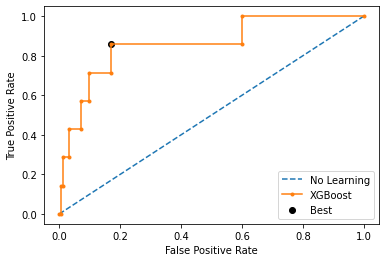

La matriz de confusión: 
 [[127  26]
 [  2   5]]
Un ejemplo de árbol de decisión.


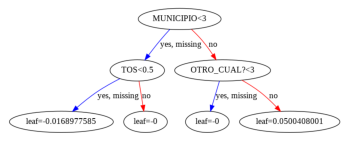

AUC Score:  0.7721755368814193


(None, <matplotlib.axes._subplots.AxesSubplot at 0x7f89a5c22710>)

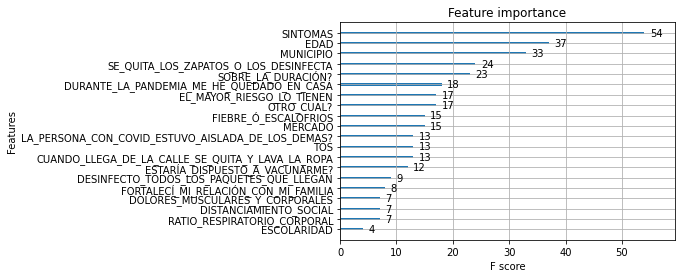

In [ ]:
#@title Modelling #1 PCR Mixto
modelling(ready_df, 'RESULTADO_PCR','RESULTADO_SEROLOGIA')

### Modelling (EDA) #2 Serología Mixto

El primer modelado fue analizando la prueba PCR del Covid. Este modelo tratará de predecir los resultados de la prueba de Serología.

Para esta prueba, no tiene mucho sentido analizar los sintomas de la persona ya que esta prueba también identifica pacientes que tuvieron la enfermedad. Por lo que descartar algunos datos podría ser de utilidad.

Split Listo 
 La proporción entre clases es: 1.3296703296703296
Best Threshold=1.499931, G-Mean=0.000


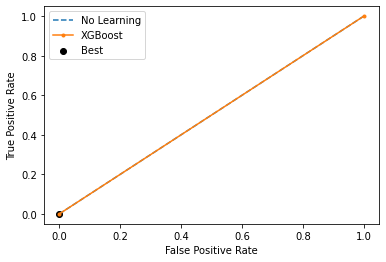

La matriz de confusión: 
 [[91  0]
 [69  0]]
Un ejemplo de árbol de decisión.


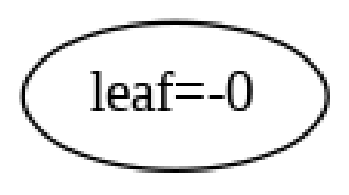

AUC Score:  0.5
Luego de 600 rondas, el modelo que busca predecir el resultado de la serología no encuentra ninguna división entre los target.


In [ ]:
#@title #####Modelado
try:
  modelling(habit_df, 'RESULTADO_SEROLOGIA','RESULTADO_PCR')
except:
  print('Luego de 600 rondas, el modelo que busca predecir el resultado de la serología no encuentra ninguna división entre los target.')

Este set de datos no tiene una referencia temporal aparente, ni un registro histórico de cada paciente, por lo que era de esperar que la prueba de serología que busca mostrar si alguien tuvo covid en el pasado no sea un target sencillo de predecir.


### Modelado #3 (PCR) Hábitos

Para seguir profundizando en la investigación de los datos, quisieramos predecir a partir de los hábitos, la probabilidad de que la prueba PCR salga positiva o negativa.


Split Listo 
 La proporción entre clases es: 21.714285714285715
Best Threshold=0.535816, G-Mean=0.770


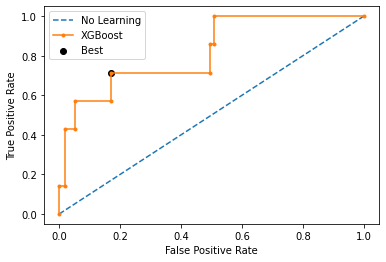

La matriz de confusión: 
 [[127  26]
 [  3   4]]
Un ejemplo de árbol de decisión.


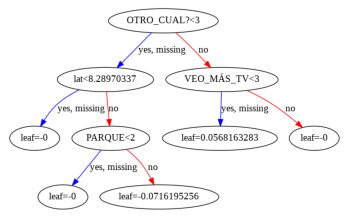

AUC Score:  0.7007469654528478


(None, <matplotlib.axes._subplots.AxesSubplot at 0x7f89a59a7c10>)

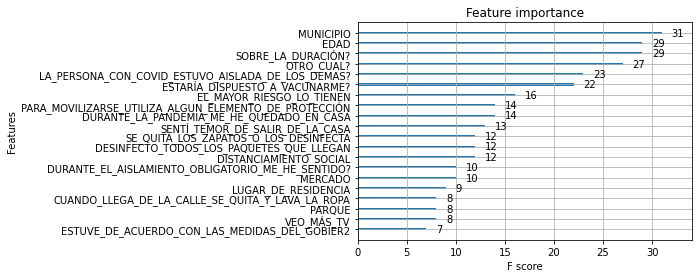

In [ ]:
#@title #####Modelado solo con los Hábitos
modelling(habit_df,'RESULTADO_PCR','RESULTADO_SEROLOGIA')

Podemos ver que suprimiendo los datos de los sintomas, el puntaje del modelo baja desde 0.8 a 0.72. Esto puede significar 2 cosas:
1. A partir de los hábitos de la persona es posible estimar si esta saldría positiva en la prueba o no.
2. Pueden existir 2 clusters de personas, los que se hicieron la prueba por precaución, sin tener sintomas, y los que ya padecían de éstos. Los síntomas están implícitos en los hábitos, por lo que el modelo está clasificando si la persona es del tipo de persona que contrae Covid, o no.

La primera afirmación es la más certera, pero para afirmar la segunda, necesitamos de un poco más de investigación.

### Modelado #4 (PCR) Síntomas

Modelando solo con los sintomas, queremos contrastar con qué podemos hacer mejores predicciones y obtener puntajes mayores. Por lo que en este apartado, excluimos el entorno de la persona y solo analizamos sus síntomas.

Split Listo 
 La proporción entre clases es: 21.714285714285715
Best Threshold=0.539203, G-Mean=0.745


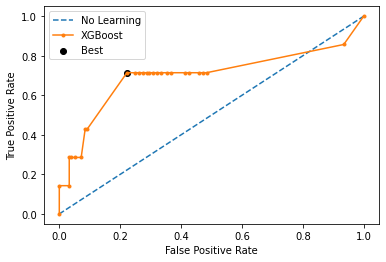

La matriz de confusión: 
 [[139  14]
 [  4   3]]
Un ejemplo de árbol de decisión.


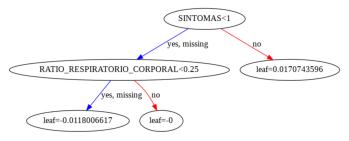

AUC Score:  0.6685340802987862


(None, <matplotlib.axes._subplots.AxesSubplot at 0x7f89a57d93d0>)

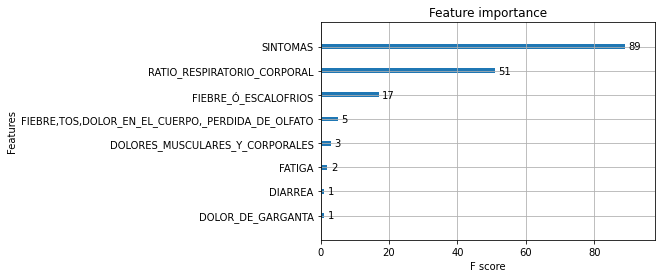

In [ ]:
#@title #####Modelado solo con los síntomas
modelling(simp_df,'RESULTADO_PCR','RESULTADO_SEROLOGIA')

Analizando los sintomas sin considerar el contexto de la persona, no se obtienen tan buenos resultados como teniendo en cuenta el contexto aisladamente. Esto puede ser por personas asíntomaticas que contrajeron el virus debido a sus hábitos.

Los mejores resultados se obtienen combinando ambos tipos de variables.

### Analisís de Falsos Positivos y Falsos Negativos Modelo #1

El modelo 1 es el modelo que obtiene el mejor puntaje de AUC, es un modelo precavido (más Falsos Positivos que Falsos Negativos), y utiliza tanto el contexto de la persona (hábitos y forma de pensar) como los sintomas que presenta. 

In [ ]:
#@title ##### Reentrenar para el análisis
%%capture
test_df = modelling(ready_df,'RESULTADO_PCR','RESULTADO_SEROLOGIA',false_analysis=True)
test_df['MUNICIPIO'] = test_df['MUNICIPIO'].astype(object).replace({1:'Lorica',
                                                                  2:'Planeta Rica',
                                                                  3:'Tierralta',
                                                                  4:'Sahagun',
                                                                  5:'Montelibano'})


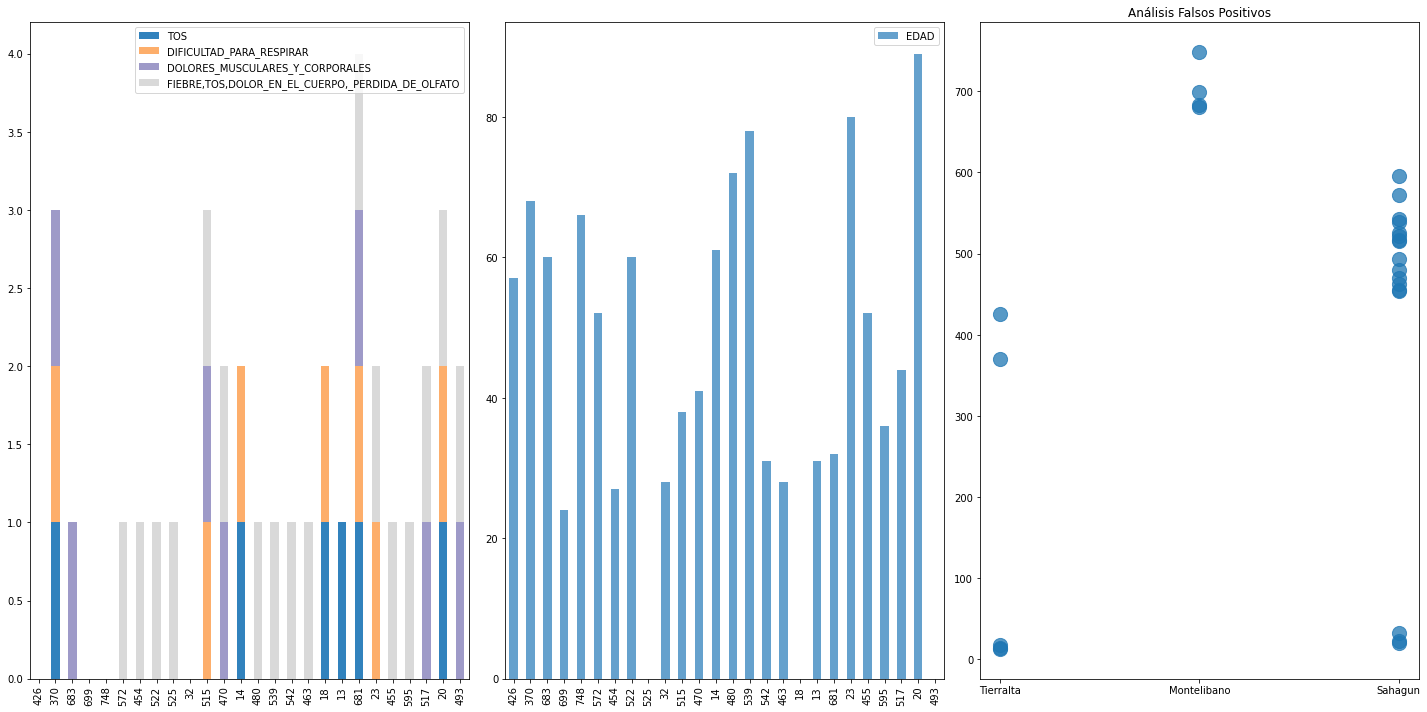

In [ ]:
#@title #####Analicemos Falsos Positivos.

fig, axs = plt.subplots(1,3)
al=0.75
falsos_positivos = test_df.loc[(test_df['Resultado']<=0.5) & (test_df['Prediccion']>=0.5)]
falsos_positivos[['TOS','DIFICULTAD_PARA_RESPIRAR','DOLORES_MUSCULARES_Y_CORPORALES','FIEBRE,TOS,DOLOR_EN_EL_CUERPO,_PERDIDA_DE_OLFATO']].plot(kind='bar',stacked=True,ax=axs[0], figsize=(20,10),colormap='tab20c')
falsos_positivos[['EDAD']].plot(kind='bar',ax=axs[1], figsize=(20,10),colormap='tab20c',alpha=al)
axs[2]=plt.scatter(falsos_positivos["MUNICIPIO"].astype(str), falsos_positivos.index,alpha=al,s=200)

# falsos_positivos[['MUNICIPIO']].plot(kind='bar',ax=axs[2], figsize=(12,18),colormap='tab20c')
fig.tight_layout()


Teniendo en cuenta la convención:

Síntomas:
1. Sí.
2. No.

Podemos ver que el Municipio que más falsos positivos genera es Sahagún, **No** tener *tos* o *dificultad para respirar*, **tener** *mareos y perdida del apetito*, tener *fiebre*, *dolores en el cuerpo o perdida del olfato*.

Esto puede suceder como resultado de la importancia que da el modelo a la variable **Municipio** para predecir pacientes infectados por covid, si un paciente vive en Sahagún, en general el modelo lo clasificaría como alguien infectado obviando un poco sus síntomas respiratorios. Sin embargo, retomando el analisis de sintomatología por cada municipio, vemos que en Sahagún, los sintomas de Covid más frecuentes fueron Vomitos, perdida de apetito, y fiebre, dolor o perdida de olfato.

Pacientes podrían pasar un mal rato con el modelo, al ser clasificados como positivos, estos pueden ser descartados con una prueba PCR, ya que en promedio, **No presentan síntomas de Tos o dificultad para respirar**, que vimos eran los más importantes en la predicción de la prueba PCR.

Por otra parte, esta precaución (bien hecha) puede ser de gran utilidad a la hora de decidir si hacerle la prueba o no a una determinada persona, de manera que podría servir de filtro inicial, o en caso que no haya disponibilidad de pruebas.

**Bonus Investigativo:**
Internacionalmente y en diversos estudios de esta enfermedad, se ha comprobado que la prueba PCR es buena detectando casos positivos en pacientes que tengan sintomatología del sistema respiratorio, **pero** si el paciente presenta síntomas como vómitos, mareos, o coagulos en sangre, sin presentar síntomas respiratorios, es posible que la prueba salga negativa, a pesar de padecer la enfermedad.

El modelo fue entrenado buscando predecir los resultados de la PCR, pero estos "Falsos positivos" con sintomatología del sistema digestivo, pueden ser "Falsos Negativos" de la prueba PCR. Por lo que podemos pensar que el modelo es más viable que la prueba al momento de predecir si una persona tiene Covid o no, esta afirmación queda a disposición de futuras investigaciones, o despliegues reales.

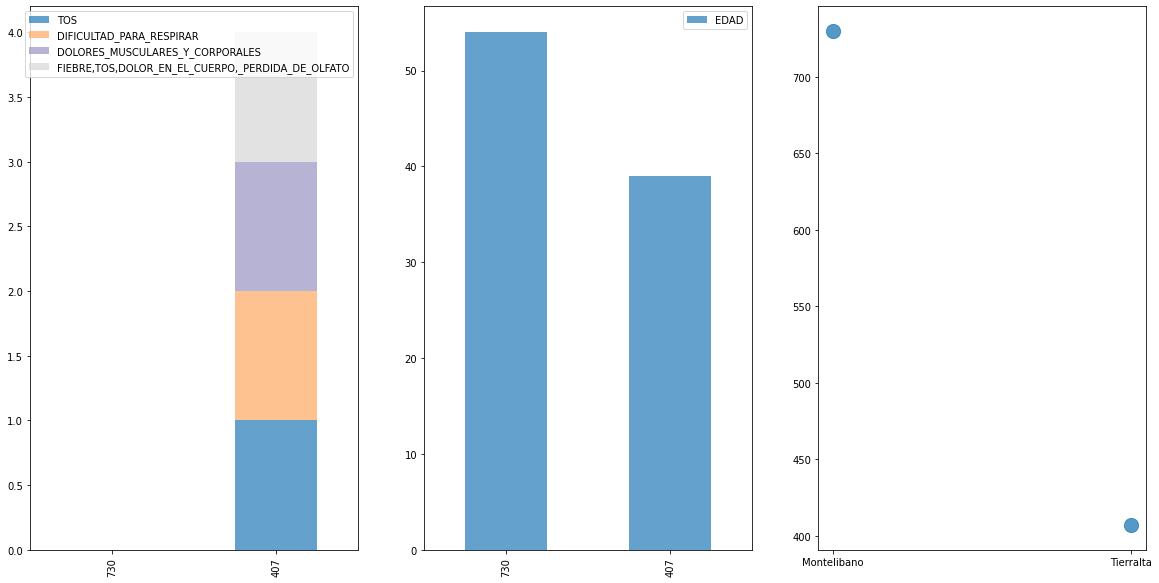

In [ ]:
#@title #####Analicemos Falsos Negativos
fig, axs = plt.subplots(1,3)
falsos_negativos = test_df.loc[(test_df['Resultado']>=0.5) & (test_df['Prediccion']<=0.5)]
al=0.75
falsos_negativos[['TOS','DIFICULTAD_PARA_RESPIRAR','DOLORES_MUSCULARES_Y_CORPORALES','FIEBRE,TOS,DOLOR_EN_EL_CUERPO,_PERDIDA_DE_OLFATO']].plot(kind='bar',stacked=True,ax=axs[0], figsize=(20,10),colormap='tab20c',alpha=al)
falsos_negativos[['EDAD']].plot(kind='bar',ax=axs[1], figsize=(20,10),colormap='tab20c',alpha=al)
axs[2]=plt.scatter(falsos_negativos["MUNICIPIO"].astype(str), falsos_negativos.index,alpha=al,s=200)


Esta es la situación que podría ser más preocupante de todas. Falso negativo sería una persona que **tiene** Covid, pero el modelo lo descartaría. 
En del paciente 730 no sería un gran problema al ser descartado, ya que no presenta sintomas de tos ni dificultad para respirar, que son los más críticos; es menos probable que empeore, contagie a otros, o siquiera sospeche de que tiene la enfermedad.

El paciente 407 sería algo peligroso. Este tiene alrededor de 40 años, es de Tierralta, presenta Tos y dificultad para respirar que son los sintomas más críticos, y aún así el modelo lo **descarta** como infectado por Covid. Podría desembocar en un agravamiento del paciente, así que lo ideal es que este tipo de casos no se presenten en el modelo.



### Análisis Verdaderos Negativos y Verdaderos Positivos Modelo #1

El análisis de los Falsos Negativos y Positivos arrojó algunas conclusiones, pero es necesario observar cuales son los pacientes que el modelo clasifica bien, y qué tienen en común.

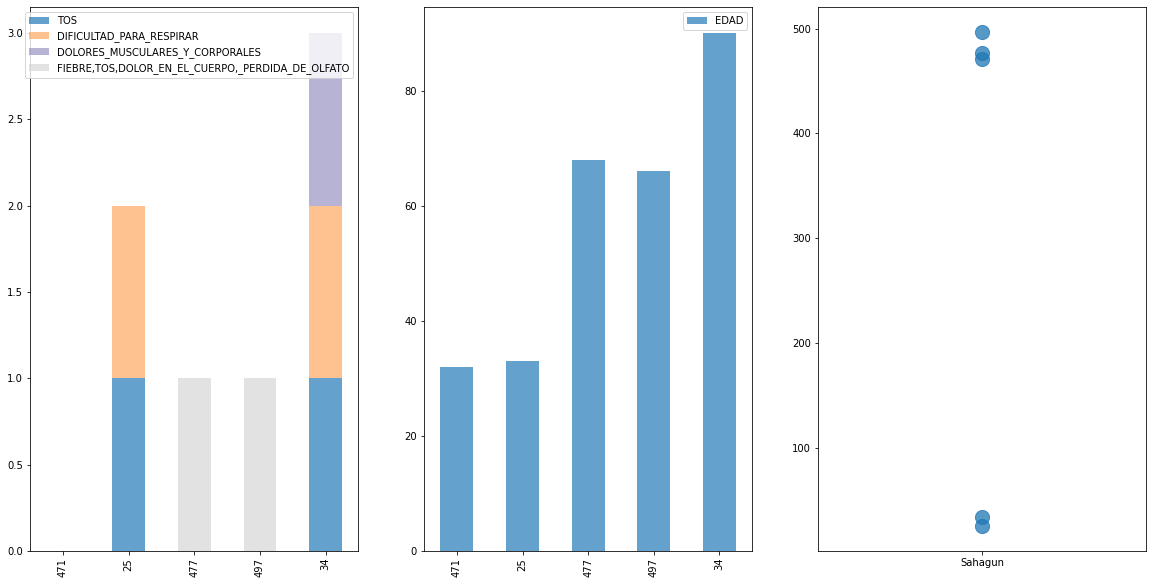

In [ ]:
#@title #####Análisis Verdaderos Positivos
verdaderos_positivos = test_df.loc[(test_df['Resultado']>=0.5) & (test_df['Prediccion']>=0.5)]
fig, axs = plt.subplots(1,3)
al=0.75
verdaderos_positivos[['TOS','DIFICULTAD_PARA_RESPIRAR','DOLORES_MUSCULARES_Y_CORPORALES','FIEBRE,TOS,DOLOR_EN_EL_CUERPO,_PERDIDA_DE_OLFATO']].plot(kind='bar',stacked=True,ax=axs[0], figsize=(20,10),colormap='tab20c',alpha=al)
verdaderos_positivos[['EDAD']].plot(kind='bar',ax=axs[1], figsize=(20,10),colormap='tab20c',alpha=al)
axs[2]=plt.scatter(verdaderos_positivos["MUNICIPIO"].astype(str), verdaderos_positivos.index,alpha=al,s=200)


Estando todos en el mismo municipio (Sahagún) el modelo fue capaz de detectar casos positivos según la prueba PCR con sintomatologías distintas, el paciente 471 podría ser clasificado gracias a sus hábitos, y ser del tipo asintomático, sin embargo, se requiere un análisis más detallado para entender cómo fue realizada la clasificación del modelo. 

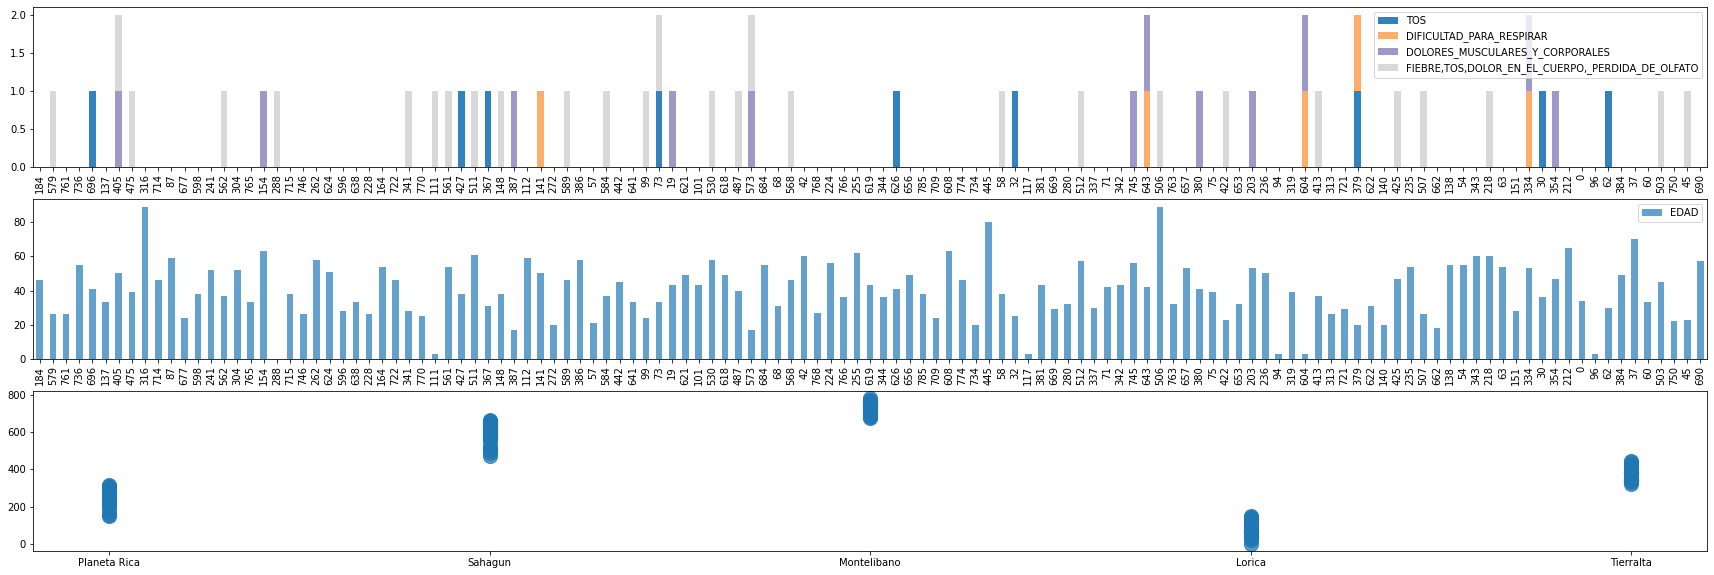

In [ ]:
#@title #####Análisis Verdaderos Negativos
verdaderos_negativos = test_df.loc[(test_df['Resultado']<=0.5) & (test_df['Prediccion']<=0.5)]
fig, axs = plt.subplots(3,1)
al=0.75
verdaderos_negativos[['TOS','DIFICULTAD_PARA_RESPIRAR','DOLORES_MUSCULARES_Y_CORPORALES','FIEBRE,TOS,DOLOR_EN_EL_CUERPO,_PERDIDA_DE_OLFATO']].plot(kind='bar',stacked=True,ax=axs[0], figsize=(30,10),colormap='tab20c')
verdaderos_negativos[['EDAD']].plot(kind='bar',ax=axs[1], figsize=(30,10),colormap='tab20c',alpha=al)
axs[2]=plt.scatter(verdaderos_negativos["MUNICIPIO"].astype(str), verdaderos_negativos.index,alpha=al,s=200)


Podemos observar que la varios pacientes negativos en la prueba PCR tienen síntomas y están repartidos por los distintos mmunicipios, éstos pueden estar contagiados de alguna otra enfermedad, ó, ser **Falsos negativos** de la PCR.

Los que no tienen síntomas fueron correctamente clasificados como negativos.